In [1]:
# check whether RF experiments can reproduce paper results
# check whether figures are exactly reproduced

# make optimised sort and slice feature extractor function (how break ties, how atom invariants, ...)

# design readme file and embedd figures
# link to the paper in readme file
# give instructions/code/functions on how to easily use sort and slice in other projects

In [2]:
def construct_sort_and_slice_ecfp_featuriser(mols_train, 
                                             max_radius = 2, 
                                             atom_inv_type = "ecfp", 
                                             use_bond_invs = True, 
                                             use_chirality = False, 
                                             use_counts = False, 
                                             fp_dimension = 1024):
    """
    Creates a function "ecfp_featuriser" that maps RDKit mol objects to vectorial ECFP fingerprints pooled via Sort & Slice (instead of traditional hash-based folding for substructure pooling).
    See also "Sort & Slice: A Simple and Superior Alternative to Hash-Based Folding for Extended-Connectivity Fingerprints" by Dablander, Hanser, Lambiotte and Morris (2024): https://arxiv.org/abs/2403.17954.
    
    INPUTS:
    
    - mols_train (list)     ...    A list of RDKit mol objects [mol_1, mol_2, ...] that are used as the training set to construct the Sort & Slice substructure pooling operator.
    - max_radius (int)      ...    The maximal radius up to which to generate the hashed integer ECFP-substructure identifiers. Common choices are 1, 2 or 3 (corresponding to diameters of 2, 4, or 6).
    - atom_inv_type (str)   ...    The type of initial atomic invariants with which to generate the hashed integer ECFP-substructure identifiers ("ecfp" for standard or "fcfp" for pharmacophoric invariants).
    - use_bond_invs (bool)  ...    Whether or not to take into account bond invariants when generating the hashed integer ECFP-substructure identifiers (default = True).
    - use_chirality (bool)  ...    Whether or not to take into account chirality when generating the hashed integer ECFP-substructure identifiers (default = False).
    - use_counts (bool)     ...    Whether to generate binary vectorial fingerprints (use_counts = False) that indicate the mere presence or absence of a substructure, or integer fingerprints (use_counts = True) that additionally indicate how many times a substructure is found in the input compound.
    - fp_dimension (int)    ...    Length of the vectorial Sort & Slice ECFP. Common choices are 512, 1024, 2048 and 4096. Only the fp_dimension most prevalent ECFP-substructures in mols_train are included in the final vector representation.
    
    OUTPUT:
    
    - ecfp_featuriser (function)    ...    A function that maps RDKit mol objects to vectorial ECFP fingerprints pooled via a Sort & Slice operator trained on mols_train.
    
    EXAMPLE:
    
    First construct a molecular featurisation function with desired settings via
    
    ecfp_featuriser = construct_sort_and_slice_ecfp_featuriser(mols_train = [mol_1, mol_2, ...], 
                                                               max_radius = 2, 
                                                               atom_inv_type = "ecfp", 
                                                               use_bond_invs = True, 
                                                               use_chirality = False, 
                                                               use_counts = False, 
                                                               fp_dimension = 1024)
                                                               
    Note that the ECFP settings (max_radius, atom_inv_type, use_bond_invs, use_chirality, use_counts, fp_dimension) and information from mols_train are all by construction implicitly transferred to "ecfp_featuriser".
    
    Now let mol be an RDKit mol object. 
    
    Then ecfp_featuriser(mol) = np.array([1, 0, 0, ..., 1, 1, 0]) is a 1-dimensional numpy array of length "fp_dimension" representing the vectorial Sort & Slice ECFP fingerprint for mol.
    
    The fingerprint ecfp_featuriser(mol) is generated by (i) first generating the (multi)set of hashed integer ECFP-substructure identifiers from mol and then (ii) vectorising it via the Sort & Slice operator trained on mols_train (rather than via classical hash-based folding).
    """
    
    
    
    
    
    
    # define function that maps molecules to list of atomic invariants
    def mol_to_invs_function(mol):

        invs = []

        for k in range(mol.GetNumAtoms()):

            if atom_inv_type == "ecfp":
                fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius = 0, atomInvariantsGenerator = rdFingerprintGenerator.GetMorganAtomInvGen(includeRingMembership = True))
            elif atom_type == "fcfp:"
                fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius = 0, atomInvariantsGenerator = rdFingerprintGenerator.GetMorganFeatureAtomInvGen())

            fingerprint = fp_gen.GetSparseCountFingerprint(mol, fromAtoms = [k])        
            invs.append(list(fingerprint.GetNonzeroElements().keys())[0])

        return invs

    
    
    
    
    
    # preallocate data structures
    atom_id_to_support_list = defaultdict(lambda: [0]*len(x_smiles)) # the support_list for a given atom_id is a binary list of len(x_smiles) whose i-th entry specifies whether the atom_id is contained in smiles_i
        
    # create set of all atom id in x_smiles and binary substructural training feature vector for each atom_id in the form of a dictionary atom_id_to_support_list
    for (k, mol) in enumerate(mols_train):
        
        current_atom_id_to_count_dict = UIntSparseIntVect.GetNonzeroElements(GetMorganFingerprint(mol, 
                                                                                                  radius = max_radius, 
                                                                                                  invariants = mol_to_invs_function(mol), 
                                                                                                  useBondTypes = use_bond_invs, 
                                                                                                  useChirality = use_chirality, 
                                                                                                  useCounts = use_counts))
        
        for atom_id in current_atom_id_to_count.keys():
            atom_id_to_support_list[atom_id][k] = 1 if current_atom_id_to_count[atom_id] > 0 else 0
            
    print("Number of unique circular substructures with specified parameters in molecular training data set = ", len(atom_id_to_support_list.keys()))
    
    # create list of atom ids sorted by prevalence in x_smiles (ties are either broken using the arbitrary ordering induced via sorted(list(...), ...) or the arbitrary ordering induced by the integer atom ids themselves)
    atom_id_list_sorted = sorted(atom_id_to_support_list.keys(), key = lambda atom_id: (sum(atom_id_to_support_list[atom_id]), -atom_id), reverse = True)
    
    # create auxiliary one-hot encoder
    def one_hot_vec(dim, k):

        vec = np.zeros(dim)
        vec[k] = 1

        return vec.astype(int)
    
    # create integer substructure identifier (= atom id) one-hot embedding
    def atom_id_one_hot_encoder(atom_id):
        
        return one_hot_vec(fp_dimension, atom_id_list_sorted.index(atom_id)) if atom_id in atom_id_list_sorted[0: fp_dimension] else np.zeros(fp_dimension)
    
    
    
    
    
    
    
    def ecfp_featuriser(mol):
        
        # create dictionary that maps detected atom ids (= integer substructure identifiers) to their count in the input molecule
        atom_id_to_count_dict = UIntSparseIntVect.GetNonzeroElements(GetMorganFingerprint(mol, 
                                                                     radius = max_radius, 
                                                                     invariants = mol_to_invs_function(mol), 
                                                                     useBondTypes = use_bond_invs, 
                                                                     useChirality = use_chirality, 
                                                                     useCounts = use_counts))
        
        # create list of integer substructure identifiers (= atom ids) in SMILES string (multiplied by their frequencies if ecfp_settings["use_counts"] = True)
        for (atom_id, count) in atom_id_to_count_dict.items():
            atom_id_list += [atom_id]*count

        # create a representation of the input compound as a (multi)set of one-hot encoded substructure emebeddings
        vector_multiset = np.array([atom_id_one_hot_encoder(atom_id) for atom_id in atom_id_list])
        
        # sum up one-hot encoded substructure embeddings to create molecule-wide representation
        ecfp_vector = np.sum(vector_multiset, axis = 0)
    
        return ecfp_vector
    
    
    
    
    
    
    
    
    return ecfp_featuriser

# Import Packages

In [1]:
# import general packages and set general options
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
import warnings
warnings.filterwarnings("ignore")

# import custom code written for this project
from modules import *

# import and check funtionality of pytorch
import torch
print("Pytorch version = ", torch.__version__)
print("CUDA version = ", torch.version.cuda)
print("CUDA available = ", torch.cuda.is_available())
print("Random Pytorch test tensor = ", torch.rand(1))

Pytorch version =  1.10.2+cu113
CUDA version =  11.3
CUDA available =  False
Random Pytorch test tensor =  tensor([0.8467])


# Load and Prepare Data

In [2]:
# initialise dictionary used to store experimental settings, after dictionary is initialised, choose one of the five data sets below to proceed

settings_dict = {}

In [3]:
# LIT-PCBA Estrogen Receptor Alpha Antagonism

settings_dict["dataset_name"] = "lit_pcba_esr_ant"
settings_dict["task_type"] = "classification"
settings_dict["prop_name"] = "Activity"

In [3]:
# MoleculeNet Lipophilicity

settings_dict["dataset_name"] = "moleculenet_lipophilicity"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "exp"

In [7]:
# AqSolDB solubility

settings_dict["dataset_name"] = "aqsoldb_solubility"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "Solubility"

In [3]:
# PostEra SARS-CoV-2 Mpro inhibition

settings_dict["dataset_name"] = "postera_sars_cov_2_mpro"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "f_avg_IC50"

In [33]:
# Ames mutagenicity

settings_dict["dataset_name"] = "ames_mutagenicity"
settings_dict["task_type"] = "classification"
settings_dict["prop_name"] = "Activity"

In [4]:
# load clean data

dataframe = pd.read_csv("data/" + settings_dict["dataset_name"] + "/" + "clean_data.csv", sep = ",")
display(dataframe)

SMILES  Activity
0            CN(C(=O)CCCOc1ccc2[nH]c(=O)ccc2c1)C1CCCCC1         1
1     C[C@@H]1O[C@@H](O[C@@H]2C=C3CC[C@@H]4[C@H](CC[...         1
2             COc1ccc2cc3-c4cc5c(cc4CC[n+]3cc2c1OC)OCO5         1
3                               N=C(N)NC(=N)NCCc1ccccc1         1
4     CC(=O)N1CCN(c2ccc(OC[C@H]3CO[C@](Cn4ccnc4)(c4c...         1
...                                                 ...       ...
3916       CN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc32)CC1         0
3917    Cc1cc(N)c2cc(NC(=O)Nc3ccc4nc(C)cc(N)c4c3)ccc2n1         0
3918                                NC(Cc1ccccc1)C(=O)O         0
3919    C=C[C@H]1CN2CCC1C[C@@H]2[C@@H](O)c1ccnc2ccccc12         0
3920       CC1(C)[C@@H]2CC[C@@]1(C)[C@H](OC(=O)CSC#N)C2         0

[3921 rows x 2 columns]

Mean Value (Target) =  0.022443254271869422
Standard Deviation (Target) =  0.14812006822020315
Maximum Value (Target) =  1.0
Minimum Value (Target) =  0.0 

Shape of y =  (3921,)

 y =  [1. 1. 1. ... 0. 0. 0.]


(array([3833.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          88.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

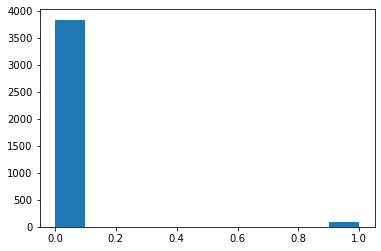

In [5]:
# construct target variable y (for the SARS-CoV-2 main protease data set, we convert Ki to pKi by taking negative decadic logarithm)

if settings_dict["dataset_name"] == "postera_sars_cov_2_mpro":
    y = -np.log10(dataframe.loc[:, settings_dict["prop_name"]].values.astype(float))
else:
    y = dataframe.loc[:, settings_dict["prop_name"]].values.astype(float)

print("Mean Value (Target) = ", np.mean(y))
print("Standard Deviation (Target) = ", np.std(y))
print("Maximum Value (Target) = ", np.amax(y))
print("Minimum Value (Target) = ", np.amin(y), "\n")

print("Shape of y = ", y.shape)
print("\n y = ", y)

plt.hist(y)

Shape of x_smiles =  (3921,)
CN(C(=O)CCCOc1ccc2[nH]c(=O)ccc2c1)C1CCCCC1


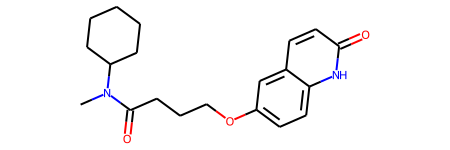

In [6]:
# extract SMILES strings

x_smiles = np.reshape(dataframe["SMILES"].values, (len(dataframe), 1))[:,0]

print("Shape of x_smiles = ", x_smiles.shape)
print(x_smiles[0])
display(Chem.MolFromSmiles(x_smiles[0]))

In [7]:
# create dictionary that maps smiles strings to their target values

x_smiles_to_y_dict = dict(list(zip(x_smiles, y)))

# Prepare Data Split

In [8]:
# choose settings for dictionary that contains indices for data splits

settings_dict["split_type"] = "scaff" # choose "rand" for random split and "scaff" for scaffold split
settings_dict["split_type_rand_stratified"] = False # given a random split and a classification problem, choose whether to stratify the split
settings_dict["k_splits"] = 2 # choose number of cross validation folds k_splits
settings_dict["m_reps"] = 3 # choose number of random seeds m_reps with which the cross validation scheme is repeated
settings_dict["random_state_cv"] = 42 # choose random state

In [9]:
# construct dictionary that contains indices for data splits

if settings_dict["split_type"] == "rand" and settings_dict["split_type_rand_stratified"] == False:
    
    data_split_dict = create_data_split_dict_random(x_smiles = x_smiles,
                                                    k_splits = settings_dict["k_splits"],
                                                    m_reps = settings_dict["m_reps"],
                                                    random_state_cv = settings_dict["random_state_cv"])

elif settings_dict["split_type"] == "rand" and settings_dict["split_type_rand_stratified"] == True:
    
    data_split_dict = create_data_split_dict_random_strat(x_smiles = x_smiles,
                                                          y = y,
                                                          k_splits = settings_dict["k_splits"],
                                                          m_reps = settings_dict["m_reps"],
                                                          random_state_cv = settings_dict["random_state_cv"])
    
elif settings_dict["split_type"] == "scaff":
    
    data_split_dict = create_data_split_dict_scaffold(x_smiles = x_smiles,
                                                      k_splits = settings_dict["k_splits"],
                                                      m_reps = settings_dict["m_reps"],
                                                      scaffold_func = "Bemis_Murcko_generic",
                                                      random_state_cv = settings_dict["random_state_cv"])

# Evaluate Models

In [10]:
# choose ECFP hyperparameters

settings_dict["ecfp_settings"] = {"mol_to_invs_function": fcfp_invariants, # ecfp_invariants or fcfp_invariants
                                  "radius": 1, # 0 or 1 or 2 or 3 ...
                                  "pool_method": "filtered", # "hashed" or "sort_and_slice" or "filtered" or "mim"
                                  "dimension": 1024, # 256 or 512 or 1024 or 2048 or 4096 ...
                                  "use_bond_invs": True, # True or False
                                  "use_chirality": True, # True or False
                                  "use_counts": False} # True or False

In [11]:
# chose ml model: random forest or multilayer perceptron

settings_dict["ml_model"] = "rf" # "rf" or "mlp"

In [12]:
# choose rf hyperparameters

settings_dict["rf_settings"] = {"n_estimators" : 100,
                                "max_depth" : None,
                                "min_samples_leaf" : 1,
                                "min_samples_split" : 2,
                                "bootstrap" : True,
                                "max_features": "sqrt",
                                "random_state" : 42}

if settings_dict["task_type"] == "regression":

    settings_dict["rf_settings"]["criterion"] = "squared_error"

elif settings_dict["task_type"] == "classification":

    settings_dict["rf_settings"]["criterion"] = "gini"

In [13]:
# choose mlp hyperparameters

settings_dict["mlp_settings"] = {"architecture" : list(arch(settings_dict["ecfp_settings"]["dimension"], 1, 512, 5)),
                                "hidden_activation" : nn.ReLU(),
                                "use_bias" : True,
                                "hidden_dropout_rate" : 0.25,
                                "hidden_batchnorm" : True,
                                "batch_size" : 64,
                                "dataloader_shuffle" : True,
                                "dataloader_drop_last" : True,
                                "learning_rate" : 1e-3,
                                "lr_lambda" : lambda epoch: max(0.98**epoch, 1e-2),
                                "lr_last_epoch": 0,
                                "weight_decay" : 0.1,
                                "num_epochs" : 0,
                                "optimiser" : torch.optim.AdamW,
                                "print_results_per_epochs" : None}

if settings_dict["task_type"] == "regression":

    settings_dict["mlp_settings"]["output_activation"] = nn.Identity()
    settings_dict["mlp_settings"]["loss_function"] = nn.MSELoss()
    settings_dict["mlp_settings"]["performance_metrics"] = "regression"

elif settings_dict["task_type"] == "classification":

    settings_dict["mlp_settings"]["output_activation"] = nn.Sigmoid()
    settings_dict["mlp_settings"]["loss_function"] = nn.BCELoss()
    settings_dict["mlp_settings"]["performance_metrics"] = "classification"

In [39]:
%%time
# run model and save results

# dictionary to save results over the k_splits-fold cross validation with m_reps random seeds
scores_dict = {}

# ind_train and ind_test contain the indices for the data split corresponding to the k-th fold with the m-th random seed
for ((m, k), (ind_train, ind_test)) in data_split_dict.items():
    
    # create ecfp featuriser
    featuriser = create_ecfp_featuriser(ecfp_settings = settings_dict["ecfp_settings"], 
                                        x_smiles_train = x_smiles[ind_train], 
                                        y_train = y[ind_train], 
                                        discretise_y = True if settings_dict["task_type"] == "regression" else False,
                                        base = 2, 
                                        random_state = 42)
    
    # create ecfp-based feature matrices
    X_train = featuriser(x_smiles[ind_train])
    X_test = featuriser(x_smiles[ind_test])

    # create ml model + train ml model + make predictions on test set
    if settings_dict["ml_model"] == "rf":
        
        rf_model = create_rf_model(settings_dict["rf_settings"], settings_dict["task_type"])
        rf_model.fit(X_train, y[ind_train])
        y_test_pred = make_rf_prediction(rf_model, X_test, settings_dict["task_type"])
        
    if settings_dict["ml_model"] == "mlp":
        
        mlp_model = create_mlp_model(settings_dict["mlp_settings"])
        (loss_curve_train, loss_curve_test) = train_mlp_model(mlp_model, settings_dict["mlp_settings"], X_train, y[ind_train], X_test, y[ind_test])
        plt.plot(loss_curve_train)
        plt.plot(loss_curve_test)
        y_test_pred = make_mlp_prediction(mlp_model, X_test)
        
    # record scores
    print(m, k)
    if settings_dict["task_type"] == "regression":
        scores_dict[(m, k)] = regression_scores(y[ind_test], y_test_pred, display_results = True)
    elif settings_dict["task_type"] == "classification":
        scores_dict[(m, k)] = binary_classification_scores(y[ind_test], y_test_pred, display_results = True)
        
# summarise, display and save scores for this experiment
summarise_display_and_save_results_and_settings(scores_dict, settings_dict, display_results = True)

old function with new padding without add dim
Number of unique substructures =  530
0 0


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
Scores:  0.069289  0.589113  0.976577           0.512513   0.04878  0.109276   

         Sensitivity  Specificity  Precision  Negative Predictive Value  \
Scores:     0.025641     0.999385        0.5                    0.97715   

         Test Cases  Negative Test Cases  Positive Test Cases  
Scores:      1665.0               1626.0                 39.0

old function with new padding without add dim
Number of unique substructures =  531
0 1


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
Scores:  0.047231  0.576417   0.97695           0.519275  0.071429  0.101039   

         Sensitivity  Specificity  Precision  Negative Predictive Value  \
Scores:     0.040816     0.997734   0.285714                   0.979102   

         Test Cases  Negative Test Cases  Positive Test Cases  
Scores:      2256.0               2207.0                 49.0

old function with new padding without add dim
Number of unique substructures =  512
1 0


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
Scores:  0.060683  0.587932  0.972904           0.499475       0.0 -0.005235   

         Sensitivity  Specificity  Precision  Negative Predictive Value  \
Scores:          0.0      0.99895        0.0                     0.9739   

         Test Cases  Negative Test Cases  Positive Test Cases  
Scores:      1956.0               1905.0                 51.0

old function with new padding without add dim
Number of unique substructures =  554
1 1


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
Scores:  0.028466  0.537092   0.97659            0.51092  0.041667  0.039788   

         Sensitivity  Specificity  Precision  Negative Predictive Value  \
Scores:     0.027027     0.994813   0.090909                   0.981576   

         Test Cases  Negative Test Cases  Positive Test Cases  
Scores:      1965.0               1928.0                 37.0

old function with new padding without add dim
Number of unique substructures =  474
2 0


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score  MCC  \
Scores:  0.059623  0.585155  0.968383                0.5       0.0  0.0   

         Sensitivity  Specificity  Precision  Negative Predictive Value  \
Scores:          0.0          1.0        NaN                   0.968383   

         Test Cases  Negative Test Cases  Positive Test Cases  
Scores:      1961.0               1899.0                 62.0

old function with new padding without add dim
Number of unique substructures =  556
2 1


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score      MCC  \
Scores:  0.040648  0.590943  0.986735           0.518972  0.071429  0.13597   

         Sensitivity  Specificity  Precision  Negative Predictive Value  \
Scores:     0.038462     0.999483        0.5                   0.987232   

         Test Cases  Negative Test Cases  Positive Test Cases  
Scores:      1960.0               1934.0                 26.0

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.069289  0.589113  0.976577           0.512513  0.048780  0.109276   
(0, 1)  0.047231  0.576417  0.976950           0.519275  0.071429  0.101039   
(1, 0)  0.060683  0.587932  0.972904           0.499475  0.000000 -0.005235   
(1, 1)  0.028466  0.537092  0.976590           0.510920  0.041667  0.039788   
(2, 0)  0.059623  0.585155  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.040648  0.590943  0.986735           0.518972  0.071429  0.135970   
mean    0.050990  0.577775  0.976357           0.510193  0.038884  0.063473   
std     0.013734  0.018782  0.005533           0.008003  0.029575  0.054887   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.025641     0.999385   0.500000                   0.977150   
(0, 1)     0.040816     0.997734   0.285714                   0.979102   
(1, 0)     0.000000     0.998950   0.000000                   0.973900   
(1, 1)     0.027027     0.994813   0.090909                   0.981576   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.038462     0.999483   0.500000                   0.987232   
mean       0.021991     0.998394   0.275325                   0.977890   
std        0.016490     0.001747   0.205367                   0.005904   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

CPU times: user 1min 9s, sys: 12 ms, total: 1min 9s
Wall time: 1min 9s


In [20]:
%%time
# run full battery of experiments for one data set and data splitting type with both rfs and mlps

# first clear folder from previous experimental results
#delete_all_files_in_folder("results/" + settings_dict["dataset_name"] + "/" + settings_dict["split_type"] + "/")

#for pool_method in ["hashed", "filtered", "mim", "sort_and_slice"]:
for pool_method in ["filtered"]:
    for dimension in [512, 1024, 2048, 4096]:
        for inv_func in [ecfp_invariants, fcfp_invariants]:
            for radius in [1, 2, 3]:

                print("pool_method = ", pool_method)
                print("dimension = ", dimension)
                print("inv_func = ", inv_func)
                print("radius = ", radius, "\n")

                # choose ECFP hyperparameters
                settings_dict["ecfp_settings"] = {"mol_to_invs_function": inv_func,
                                                  "radius": radius,
                                                  "pool_method": pool_method,
                                                  "dimension": dimension,
                                                  "use_bond_invs": True,
                                                  "use_chirality": True,
                                                  "use_counts": False}

                # run rf- and mlp models and save results
                scores_dict_rf = {}
                scores_dict_mlp = {}

                # ind_train and ind_test contain the indices for the data split corresponding to the k-th fold with the m-th random seed
                for ((m, k), (ind_train, ind_test)) in data_split_dict.items():
                    
                    # create ecfp featuriser
                    featuriser = create_ecfp_featuriser(ecfp_settings = settings_dict["ecfp_settings"], 
                                                        x_smiles_train = x_smiles[ind_train], 
                                                        y_train = y[ind_train], 
                                                        discretise_y = True if settings_dict["task_type"] == "regression" else False,  
                                                        base = 2, 
                                                        random_state = 42)

                    # create ecfp-based feature matrices
                    X_train = featuriser(x_smiles[ind_train])
                    X_test = featuriser(x_smiles[ind_test])
                    
                    # create rf model + train ml model + make predictions on test set
                    rf_model = create_rf_model(settings_dict["rf_settings"], settings_dict["task_type"])
                    rf_model.fit(X_train, y[ind_train])
                    y_test_pred = make_rf_prediction(rf_model, X_test, settings_dict["task_type"])

                    # record rf scores
                    print(m, k, "rf")
                    if settings_dict["task_type"] == "regression":
                        scores_dict_rf[(m, k)] = regression_scores(y[ind_test], y_test_pred, display_results = False)
                    elif settings_dict["task_type"] == "classification":
                        scores_dict_rf[(m, k)] = binary_classification_scores(y[ind_test], y_test_pred, display_results = False)
                    
                    # create mlp model + train ml model + make predictions on test set
                    settings_dict["mlp_settings"]["architecture"][0] = dimension
                    mlp_model = create_mlp_model(settings_dict["mlp_settings"])
                    (loss_curve_train, loss_curve_test) = train_mlp_model(mlp_model, settings_dict["mlp_settings"], X_train, y[ind_train], X_test, y[ind_test])
                    y_test_pred = make_mlp_prediction(mlp_model, X_test)

                    # record mlp scores
                    print(m, k, "mlp")
                    if settings_dict["task_type"] == "regression":
                        scores_dict_mlp[(m, k)] = regression_scores(y[ind_test], y_test_pred, display_results = False)
                    elif settings_dict["task_type"] == "classification":
                        scores_dict_mlp[(m, k)] = binary_classification_scores(y[ind_test], y_test_pred, display_results = False) 
                    
                # summarise, display and save scores for this experiment
                settings_dict["ml_model"] = "rf"
                summarise_display_and_save_results_and_settings(scores_dict_rf, settings_dict, display_results = True)
                settings_dict["ml_model"] = "mlp"
                summarise_display_and_save_results_and_settings(scores_dict_mlp, settings_dict, display_results = True)
                print("\n \n \n")

pool_method =  filtered
dimension =  512
inv_func =  <function ecfp_invariants at 0x7fdcf4adb710>
radius =  1 

old function with new padding without add dim
Number of unique substructures =  2137
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  2286
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  2025
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  2351
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  1773
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  2411
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.161234  0.721355  0.976577           0.512513  0.048780  0.109276   
(0, 1)  0.082494  0.616688  0.978280           0.509978  0.039216  0.097737   
(1, 0)  0.121316  0.710653  0.973415           0.499738  0.000000 -0.003701   
(1, 1)  0.074727  0.625624  0.980662           0.499741  0.000000 -0.003126   
(2, 0)  0.077982  0.622930  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.043455  0.597019  0.986224           0.499741  0.000000 -0.002620   
mean    0.093535  0.649045  0.977257           0.503618  0.014666  0.032928   
std     0.037817  0.048319  0.005583           0.005443  0.020924  0.050031   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.025641     0.999385   0.500000                   0.977150   
(0, 1)     0.020408     0.999547   0.500000                   0.978705   
(1, 0)     0.000000     0.999475   0.000000                   0.973913   
(1, 1)     0.000000     0.999481   0.000000                   0.981161   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.000000     0.999483   0.000000                   0.986728   
mean       0.007675     0.999562   0.200000                   0.977673   
std        0.010959     0.000202   0.244949                   0.005714   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.023249  0.438626  0.481081           0.434005  0.033557 -0.039940   
(0, 1)  0.022321  0.410974  0.488032           0.439007  0.031852 -0.035567   
(1, 0)  0.058638  0.528393  0.518916           0.514482  0.052367  0.009237   
(1, 1)  0.036448  0.606987  0.550127           0.558680  0.045356  0.032049   
(2, 0)  0.027871  0.432112  0.491586           0.480053  0.054976 -0.013962   
(2, 1)  0.019262  0.353094  0.476531           0.393246  0.015355 -0.048887   
mean    0.031298  0.461698  0.501045           0.469912  0.038911 -0.016178   
std     0.013391  0.082998  0.025777           0.054911  0.013626  0.028830   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.384615     0.483395   0.017544                   0.970370   
(0, 1)     0.387755     0.490258   0.016608                   0.973022   
(1, 0)     0.509804     0.519160   0.027601                   0.975345   
(1, 1)     0.567568     0.549793   0.023622                   0.985130   
(2, 0)     0.467742     0.492364   0.029204                   0.965909   
(2, 1)     0.307692     0.478800   0.007874                   0.980932   
mean       0.437529     0.502295   0.020409                   0.975118   
std        0.086777     0.024810   0.007294                   0.006401   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  512
inv_func =  <function ecfp_invariants at 0x7fdcf4adb710>
radius =  2 

old function with new padding without add dim
Number of unique substructures =  11456
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  10924
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  10398
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  11782
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  7820
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  13578
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.148742  0.741145  0.976577           0.512513  0.048780  0.109276   
(0, 1)  0.078464  0.578674  0.978280           0.519955  0.075472  0.138283   
(1, 0)  0.079870  0.696691  0.973415           0.499738  0.000000 -0.003701   
(1, 1)  0.055650  0.646952  0.980662           0.499741  0.000000 -0.003126   
(2, 0)  0.104583  0.650474  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.025661  0.612819  0.986224           0.499741  0.000000 -0.002620   
mean    0.082162  0.654459  0.977257           0.505281  0.020709  0.039685   
std     0.038405  0.052990  0.005583           0.008038  0.030283  0.060061   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.025641     0.999385   0.500000                   0.977150   
(0, 1)     0.040816     0.999094   0.500000                   0.979130   
(1, 0)     0.000000     0.999475   0.000000                   0.973913   
(1, 1)     0.000000     0.999481   0.000000                   0.981161   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.000000     0.999483   0.000000                   0.986728   
mean       0.011076     0.999486   0.200000                   0.977744   
std        0.016265     0.000267   0.244949                   0.005729   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.068382  0.551424  0.485886           0.511543  0.046771  0.006987   
(0, 1)  0.038610  0.511554  0.539450           0.505197  0.042396  0.003040   
(1, 0)  0.055410  0.409819  0.481084           0.428269  0.036087 -0.045736   
(1, 1)  0.019811  0.366197  0.503308           0.375771  0.018109 -0.067565   
(2, 0)  0.037509  0.540522  0.480367           0.544472  0.069406  0.031171   
(2, 1)  0.014137  0.436182  0.495408           0.459729  0.021761 -0.018430   
mean    0.038977  0.469283  0.497584           0.470830  0.039088 -0.015089   
std     0.018803  0.069363  0.020395           0.056617  0.017022  0.033317   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.538462     0.484625   0.024447                   0.977667   
(0, 1)     0.469388     0.541006   0.022201                   0.978689   
(1, 0)     0.372549     0.483990   0.018962                   0.966457   
(1, 1)     0.243243     0.508299   0.009404                   0.972222   
(2, 0)     0.612903     0.476040   0.036786                   0.974138   
(2, 1)     0.423077     0.496381   0.011168                   0.984615   
mean       0.443270     0.498390   0.020495                   0.975631   
std        0.118279     0.021659   0.009095                   0.005660   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  512
inv_func =  <function ecfp_invariants at 0x7fdcf4adb710>
radius =  3 

old function with new padding without add dim
Number of unique substructures =  25528
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  22293
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  22538
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  24992
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  16093
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  30184
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.139928  0.719841  0.975976           0.499692  0.000000 -0.003797   
(0, 1)  0.067043  0.635025  0.978280           0.519955  0.075472  0.138283   
(1, 0)  0.072035  0.625151  0.973926           0.509541  0.037736  0.095148   
(1, 1)  0.049732  0.626949  0.980662           0.499741  0.000000 -0.003126   
(2, 0)  0.111572  0.634757  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.035252  0.536890  0.986224           0.499741  0.000000 -0.002620   
mean    0.079260  0.629769  0.977242           0.504779  0.018868  0.037315   
std     0.035904  0.052948  0.005546           0.007664  0.028821  0.057521   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.000000     0.999385   0.000000                   0.976562   
(0, 1)     0.040816     0.999094   0.500000                   0.979130   
(1, 0)     0.019608     0.999475   0.500000                   0.974411   
(1, 1)     0.000000     0.999481   0.000000                   0.981161   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.000000     0.999483   0.000000                   0.986728   
mean       0.010071     0.999486   0.200000                   0.977729   
std        0.015502     0.000267   0.244949                   0.005692   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.057786  0.590248  0.541141           0.539833  0.052109  0.024173   
(0, 1)  0.017489  0.406924  0.503103           0.456687  0.034453 -0.025257   
(1, 0)  0.058868  0.614081  0.518916           0.552648  0.059940  0.033572   
(1, 1)  0.035061  0.492570  0.474300           0.493531  0.035481 -0.003522   
(2, 0)  0.039683  0.556974  0.511984           0.568597  0.075362  0.048013   
(2, 1)  0.015522  0.382269  0.453571           0.419557  0.018332 -0.036953   
mean    0.037401  0.507178  0.500503           0.505142  0.045946  0.006671   
std     0.017138  0.088200  0.028920           0.053688  0.018723  0.030999   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.538462     0.541205   0.027379                   0.979955   
(0, 1)     0.408163     0.505211   0.017986                   0.974650   
(1, 0)     0.588235     0.517060   0.031579                   0.979125   
(1, 1)     0.513514     0.473548   0.018375                   0.980666   
(2, 0)     0.629032     0.508162   0.040082                   0.976721   
(2, 1)     0.384615     0.454498   0.009390                   0.982123   
mean       0.510337     0.499947   0.024132                   0.978873   
std        0.088697     0.028439   0.010072                   0.002499   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  512
inv_func =  <function fcfp_invariants at 0x7fdcf4adb9e0>
radius =  1 

old function with new padding without add dim
Number of unique substructures =  530
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  531
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  512
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  554
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  474
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  556
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.139786  0.765115  0.975976           0.512206  0.047619  0.087057   
(0, 1)  0.102014  0.716255  0.978280           0.519955  0.075472  0.138283   
(1, 0)  0.072403  0.685976  0.972904           0.499475  0.000000 -0.005235   
(1, 1)  0.043457  0.652637  0.980662           0.512995  0.050000  0.090478   
(2, 0)  0.116473  0.688580  0.968893           0.508065  0.031746  0.125008   
(2, 1)  0.061435  0.649282  0.986735           0.518972  0.071429  0.135970   
mean    0.089261  0.692974  0.977242           0.511945  0.046044  0.095260   
std     0.033197  0.039477  0.005672           0.006895  0.025341  0.049299   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.025641     0.998770   0.333333                   0.977136   
(0, 1)     0.040816     0.999094   0.500000                   0.979130   
(1, 0)     0.000000     0.998950   0.000000                   0.973900   
(1, 1)     0.027027     0.998963   0.333333                   0.981651   
(2, 0)     0.016129     1.000000   1.000000                   0.968878   
(2, 1)     0.038462     0.999483   0.500000                   0.987232   
mean       0.024679     0.999210   0.444444                   0.977988   
std        0.013778     0.000415   0.299176                   0.005782   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.022241  0.430284  0.481081           0.446518  0.035714 -0.032369   
(0, 1)  0.025797  0.458994  0.516401           0.433551  0.030222 -0.038786   
(1, 0)  0.042407  0.629365  0.544990           0.585117  0.067086  0.054415   
(1, 1)  0.022501  0.488281  0.498728           0.505979  0.037146  0.003251   
(2, 0)  0.030001  0.460149  0.480367           0.482062  0.055607 -0.012564   
(2, 1)  0.011186  0.370635  0.475000           0.373499  0.013423 -0.057933   
mean    0.025689  0.472951  0.499428           0.471121  0.039866 -0.013998   
std     0.009403  0.078897  0.024702           0.065672  0.017347  0.036199   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.410256     0.482780   0.018670                   0.971535   
(0, 1)     0.346939     0.520163   0.015799                   0.972881   
(1, 0)     0.627451     0.542782   0.035437                   0.981956   
(1, 1)     0.513514     0.498444   0.019270                   0.981614   
(2, 0)     0.483871     0.480253   0.029499                   0.966102   
(2, 1)     0.269231     0.477766   0.006883                   0.979852   
mean       0.441877     0.500365   0.020926                   0.975657   
std        0.116299     0.023872   0.009268                   0.005899   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  512
inv_func =  <function fcfp_invariants at 0x7fdcf4adb9e0>
radius =  2 

old function with new padding without add dim
Number of unique substructures =  5475
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  5368
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  5036
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  5796
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  3815
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  6531
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.096917  0.689114  0.975976           0.499692  0.000000 -0.003797   
(0, 1)  0.074374  0.703217  0.978280           0.519955  0.075472  0.138283   
(1, 0)  0.076420  0.640389  0.972904           0.509017  0.036364  0.063611   
(1, 1)  0.058525  0.643020  0.980662           0.499741  0.000000 -0.003126   
(2, 0)  0.120295  0.629979  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.059997  0.581010  0.986735           0.518972  0.071429  0.135970   
mean    0.081088  0.647788  0.977157           0.507896  0.030544  0.055157   
std     0.021635  0.040071  0.005798           0.008808  0.032972  0.062486   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.000000     0.999385   0.000000                   0.976562   
(0, 1)     0.040816     0.999094   0.500000                   0.979130   
(1, 0)     0.019608     0.998425   0.250000                   0.974385   
(1, 1)     0.000000     0.999481   0.000000                   0.981161   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.038462     0.999483   0.500000                   0.987232   
mean       0.016481     0.999311   0.250000                   0.977809   
std        0.017795     0.000478   0.223607                   0.005829   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.023298  0.427918  0.512312           0.449995  0.035629 -0.030271   
(0, 1)  0.026668  0.532332  0.504433           0.477322  0.037866 -0.013224   
(1, 0)  0.023048  0.384221  0.503067           0.439555  0.037624 -0.038536   
(1, 1)  0.024481  0.529578  0.506870           0.523382  0.039643  0.012713   
(2, 0)  0.026091  0.422837  0.476798           0.441213  0.046468 -0.041170   
(2, 1)  0.017065  0.505787  0.482143           0.471979  0.023099 -0.012831   
mean    0.023442  0.467112  0.497604           0.467241  0.036722 -0.020553   
std     0.003145  0.057762  0.013233           0.028917  0.006981  0.018542   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.384615     0.515375   0.018680                   0.972158   
(0, 1)     0.448980     0.505664   0.019766                   0.976378   
(1, 0)     0.372549     0.506562   0.019812                   0.967904   
(1, 1)     0.540541     0.506224   0.020576                   0.982880   
(2, 0)     0.403226     0.479200   0.024655                   0.960929   
(2, 1)     0.461538     0.482420   0.011846                   0.985216   
mean       0.435241     0.499241   0.019223                   0.974244   
std        0.056989     0.013469   0.003801                   0.008380   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  512
inv_func =  <function fcfp_invariants at 0x7fdcf4adb9e0>
radius =  3 

old function with new padding without add dim
Number of unique substructures =  16582
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  14727
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  14756
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  16412
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  10350
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  19870
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.132681  0.692221  0.975976           0.499692  0.000000 -0.003797   
(0, 1)  0.072519  0.627105  0.977837           0.519729  0.074074  0.122307   
(1, 0)  0.065574  0.671942  0.973415           0.499738  0.000000 -0.003701   
(1, 1)  0.059076  0.649469  0.980153           0.512736  0.048780  0.076812   
(2, 0)  0.103126  0.621031  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.046061  0.590784  0.986735           0.518972  0.071429  0.135970   
mean    0.079840  0.642092  0.977083           0.508478  0.032381  0.054599   
std     0.029336  0.033563  0.005679           0.008947  0.033361  0.059846   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.000000     0.999385   0.000000                   0.976562   
(0, 1)     0.040816     0.998641   0.400000                   0.979120   
(1, 0)     0.000000     0.999475   0.000000                   0.973913   
(1, 1)     0.027027     0.998444   0.250000                   0.981642   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.038462     0.999483   0.500000                   0.987232   
mean       0.017717     0.999238   0.230000                   0.977809   
std        0.018222     0.000533   0.203961                   0.005927   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.039660  0.563330  0.530330           0.534298  0.050971  0.020784   
(0, 1)  0.034357  0.544076  0.534131           0.522433  0.045413  0.013110   
(1, 0)  0.039814  0.556605  0.510736           0.529365  0.055281  0.018721   
(1, 1)  0.024387  0.562928  0.495165           0.570434  0.046154  0.038303   
(2, 0)  0.036569  0.471810  0.484957           0.492233  0.057836 -0.005439   
(2, 1)  0.011898  0.377913  0.484184           0.397124  0.015579 -0.047090   
mean    0.031114  0.512777  0.506584           0.507648  0.045206  0.006398   
std     0.010029  0.068115  0.020165           0.054461  0.013982  0.027150   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.538462     0.530135   0.026752                   0.979545   
(0, 1)     0.510204     0.534662   0.023764                   0.980066   
(1, 0)     0.549020     0.509711   0.029106                   0.976861   
(1, 1)     0.648649     0.492220   0.023928                   0.986486   
(2, 0)     0.500000     0.484466   0.030693                   0.967403   
(2, 1)     0.307692     0.486556   0.007992                   0.981230   
mean       0.509004     0.506292   0.023706                   0.978599   
std        0.102126     0.020203   0.007464                   0.005782   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  1024
inv_func =  <function ecfp_invariants at 0x7fdcf4adb710>
radius =  1 

old function with new padding without add dim
Number of unique substructures =  2137
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  2286
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  2025
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  2351
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  1773
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  2411
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.173152  0.675829  0.976577           0.512513  0.048780  0.109276   
(0, 1)  0.088031  0.680576  0.978280           0.509978  0.039216  0.097737   
(1, 0)  0.115118  0.714194  0.973415           0.499738  0.000000 -0.003701   
(1, 1)  0.060419  0.623542  0.980662           0.499741  0.000000 -0.003126   
(2, 0)  0.106454  0.622153  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.047304  0.672192  0.986224           0.499741  0.000000 -0.002620   
mean    0.098413  0.664747  0.977257           0.503618  0.014666  0.032928   
std     0.041015  0.032624  0.005583           0.005443  0.020924  0.050031   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.025641     0.999385   0.500000                   0.977150   
(0, 1)     0.020408     0.999547   0.500000                   0.978705   
(1, 0)     0.000000     0.999475   0.000000                   0.973913   
(1, 1)     0.000000     0.999481   0.000000                   0.981161   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.000000     0.999483   0.000000                   0.986728   
mean       0.007675     0.999562   0.200000                   0.977673   
std        0.010959     0.000202   0.244949                   0.005714   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.030161  0.554877  0.482282           0.522211  0.048565  0.013449   
(0, 1)  0.034123  0.608014  0.514184           0.562126  0.051903  0.036230   
(1, 0)  0.091765  0.645772  0.515849           0.570156  0.063304  0.044726   
(1, 1)  0.021478  0.440241  0.482952           0.471431  0.032381 -0.015540   
(2, 0)  0.035497  0.509453  0.487506           0.516953  0.063374  0.011871   
(2, 1)  0.010683  0.369302  0.447449           0.397482  0.016349 -0.047138   
mean    0.037284  0.521277  0.488370           0.506727  0.045979  0.007266   
std     0.025786  0.094828  0.022961           0.058619  0.016869  0.031042   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.564103     0.480320   0.025375                   0.978697   
(0, 1)     0.612245     0.512007   0.027100                   0.983464   
(1, 0)     0.627451     0.512861   0.033333                   0.980924   
(1, 1)     0.459459     0.483402   0.016782                   0.978992   
(2, 0)     0.548387     0.485519   0.033630                   0.970526   
(2, 1)     0.346154     0.448811   0.008372                   0.980791   
mean       0.526300     0.487153   0.024099                   0.978899   
std        0.097001     0.021649   0.009015                   0.004055   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  1024
inv_func =  <function ecfp_invariants at 0x7fdcf4adb710>
radius =  2 

old function with new padding without add dim
Number of unique substructures =  11456
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  10924
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  10398
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  11782
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  7820
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  13578
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.169499  0.743125  0.975976           0.499692  0.000000 -0.003797   
(0, 1)  0.083434  0.591550  0.978280           0.519955  0.075472  0.138283   
(1, 0)  0.088876  0.715686  0.973926           0.500000  0.000000  0.000000   
(1, 1)  0.052972  0.655602  0.980153           0.499481  0.000000 -0.004422   
(2, 0)  0.093996  0.663218  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.026530  0.610811  0.986224           0.499741  0.000000 -0.002620   
mean    0.085885  0.663332  0.977157           0.503145  0.012579  0.021241   
std     0.044118  0.053352  0.005496           0.007520  0.028127  0.052370   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.000000     0.999385   0.000000                   0.976562   
(0, 1)     0.040816     0.999094   0.500000                   0.979130   
(1, 0)     0.000000     1.000000        NaN                   0.973926   
(1, 1)     0.000000     0.998963   0.000000                   0.981151   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.000000     0.999483   0.000000                   0.986728   
mean       0.006803     0.999487   0.125000                   0.977647   
std        0.015211     0.000401   0.216506                   0.005741   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.034028  0.473429  0.539940           0.489166  0.042500 -0.006578   
(0, 1)  0.038193  0.551344  0.488032           0.518827  0.044665  0.010982   
(1, 0)  0.040097  0.520241  0.472904           0.519484  0.053260  0.012443   
(1, 1)  0.016186  0.442736  0.460560           0.473274  0.032847 -0.014575   
(2, 0)  0.028473  0.451927  0.463029           0.457507  0.050496 -0.029810   
(2, 1)  0.028165  0.626700  0.520408           0.624175  0.038855  0.056850   
mean    0.030857  0.511063  0.490812           0.513739  0.043770  0.004885   
std     0.007931  0.064110  0.029735           0.054250  0.006846  0.027412   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.435897     0.542435   0.022339                   0.975664   
(0, 1)     0.551020     0.486633   0.023276                   0.979927   
(1, 0)     0.568627     0.470341   0.027938                   0.976035   
(1, 1)     0.486486     0.460062   0.016997                   0.979029   
(2, 0)     0.451613     0.463402   0.026743                   0.962801   
(2, 1)     0.730769     0.517580   0.019958                   0.993056   
mean       0.537402     0.490076   0.022875                   0.977752   
std        0.099001     0.030309   0.003744                   0.008864   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  1024
inv_func =  <function ecfp_invariants at 0x7fdcf4adb710>
radius =  3 

old function with new padding without add dim
Number of unique substructures =  25528
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  22293
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  22538
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  24992
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  16093
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  30184
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.151493  0.714330  0.975976           0.499692  0.000000 -0.003797   
(0, 1)  0.074420  0.601412  0.978280           0.519955  0.075472  0.138283   
(1, 0)  0.100876  0.712274  0.973926           0.509541  0.037736  0.095148   
(1, 1)  0.042016  0.623738  0.980662           0.499741  0.000000 -0.003126   
(2, 0)  0.098335  0.670034  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.029631  0.608792  0.986224           0.499741  0.000000 -0.002620   
mean    0.082795  0.655097  0.977242           0.504779  0.018868  0.037315   
std     0.040512  0.046566  0.005546           0.007664  0.028821  0.057521   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.000000     0.999385   0.000000                   0.976562   
(0, 1)     0.040816     0.999094   0.500000                   0.979130   
(1, 0)     0.019608     0.999475   0.500000                   0.974411   
(1, 1)     0.000000     0.999481   0.000000                   0.981161   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.000000     0.999483   0.000000                   0.986728   
mean       0.010071     0.999486   0.200000                   0.977729   
std        0.015502     0.000267   0.244949                   0.005692   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.047325  0.405037  0.484685           0.410824  0.029412 -0.053955   
(0, 1)  0.029129  0.490721  0.497784           0.483901  0.039016 -0.009387   
(1, 0)  0.027930  0.430652  0.509202           0.480871  0.045726 -0.012197   
(1, 1)  0.016575  0.418358  0.492621           0.436596  0.027317 -0.034473   
(2, 0)  0.036414  0.512502  0.513004           0.498913  0.059113 -0.000761   
(2, 1)  0.014924  0.488505  0.484184           0.491986  0.025072 -0.003670   
mean    0.028716  0.457629  0.496913           0.467182  0.037609 -0.019074   
std     0.011135  0.041019  0.011111           0.032147  0.011976  0.019007   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.333333     0.488315   0.015385                   0.968293   
(0, 1)     0.469388     0.498414   0.020354                   0.976909   
(1, 0)     0.450980     0.510761   0.024084                   0.972028   
(1, 1)     0.378378     0.494813   0.014170                   0.976459   
(2, 0)     0.483871     0.513955   0.031480                   0.968254   
(2, 1)     0.500000     0.483971   0.012859                   0.986301   
mean       0.435992     0.498372   0.019722                   0.974707   
std        0.059983     0.010936   0.006512                   0.006222   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  1024
inv_func =  <function fcfp_invariants at 0x7fdcf4adb9e0>
radius =  1 

old function with new padding without add dim
Number of unique substructures =  530
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  531
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  512
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  554
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  474
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  556
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.139890  0.750654  0.975976           0.512206  0.047619  0.087057   
(0, 1)  0.093307  0.700036  0.979167           0.520408  0.078431  0.199913   
(1, 0)  0.080536  0.686213  0.972904           0.499475  0.000000 -0.005235   
(1, 1)  0.044851  0.637841  0.980662           0.512995  0.050000  0.090478   
(2, 0)  0.112322  0.678303  0.968893           0.508065  0.031746  0.125008   
(2, 1)  0.053729  0.616140  0.986735           0.518972  0.071429  0.135970   
mean    0.087439  0.678198  0.977389           0.512020  0.046538  0.105532   
std     0.032666  0.043342  0.005708           0.006985  0.025931  0.061982   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.025641     0.998770   0.333333                   0.977136   
(0, 1)     0.040816     1.000000   1.000000                   0.979148   
(1, 0)     0.000000     0.998950   0.000000                   0.973900   
(1, 1)     0.027027     0.998963   0.333333                   0.981651   
(2, 0)     0.016129     1.000000   1.000000                   0.968878   
(2, 1)     0.038462     0.999483   0.500000                   0.987232   
mean       0.024679     0.999361   0.527778                   0.977991   
std        0.013778     0.000501   0.365360                   0.005783   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.030306  0.501514  0.506306           0.534511  0.050808  0.020879   
(0, 1)  0.031063  0.548653  0.518617           0.554414  0.050699  0.031741   
(1, 0)  0.036626  0.559426  0.507157           0.537070  0.056751  0.023629   
(1, 1)  0.020130  0.488547  0.486514           0.499755  0.036294 -0.000133   
(2, 0)  0.033140  0.493868  0.481387           0.482588  0.055710 -0.012194   
(2, 1)  0.018415  0.575889  0.542347           0.559403  0.032362  0.027273   
mean    0.028280  0.527983  0.507055           0.527957  0.047104  0.015199   
std     0.006694  0.034473  0.020251           0.027894  0.009380  0.015855   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.564103     0.504920   0.026602                   0.979714   
(0, 1)     0.591837     0.516991   0.026484                   0.982773   
(1, 0)     0.568627     0.505512   0.029866                   0.977665   
(1, 1)     0.513514     0.485996   0.018812                   0.981152   
(2, 0)     0.483871     0.481306   0.029557                   0.966173   
(2, 1)     0.576923     0.541882   0.016648                   0.989613   
mean       0.549812     0.506101   0.024662                   0.979515   
std        0.038134     0.020082   0.005108                   0.007032   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  1024
inv_func =  <function fcfp_invariants at 0x7fdcf4adb9e0>
radius =  2 

old function with new padding without add dim
Number of unique substructures =  5475
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  5368
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  5036
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  5796
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  3815
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  6531
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.145646  0.658333  0.975976           0.499692  0.000000 -0.003797   
(0, 1)  0.089427  0.737325  0.978280           0.519955  0.075472  0.138283   
(1, 0)  0.080171  0.671597  0.972393           0.499213  0.000000 -0.006413   
(1, 1)  0.066762  0.631659  0.980662           0.512995  0.050000  0.090478   
(2, 0)  0.110170  0.645459  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.040159  0.581696  0.986224           0.518714  0.068966  0.109534   
mean    0.088723  0.654345  0.976986           0.508428  0.032406  0.054681   
std     0.033203  0.046674  0.005725           0.009053  0.033295  0.059752   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.000000     0.999385   0.000000                   0.976562   
(0, 1)     0.040816     0.999094   0.500000                   0.979130   
(1, 0)     0.000000     0.998425   0.000000                   0.973886   
(1, 1)     0.027027     0.998963   0.333333                   0.981651   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.038462     0.998966   0.333333                   0.987225   
mean       0.017717     0.999139   0.233333                   0.977806   
std        0.018222     0.000479   0.200000                   0.005930   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.022013  0.415886  0.492492           0.452361  0.036488 -0.028821   
(0, 1)  0.028412  0.576145  0.534131           0.562343  0.052299  0.036417   
(1, 0)  0.038516  0.528084  0.476483           0.511780  0.051852  0.007519   
(1, 1)  0.025358  0.483907  0.503817           0.482064  0.033697 -0.009752   
(2, 0)  0.028229  0.460302  0.504844           0.463495  0.050831 -0.025555   
(2, 1)  0.018794  0.448154  0.516327           0.489301  0.024691 -0.004899   
mean    0.026887  0.485413  0.504682           0.493557  0.041643 -0.004182   
std     0.006204  0.053085  0.018016           0.036089  0.010640  0.021911   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.410256     0.494465   0.019093                   0.972189   
(0, 1)     0.591837     0.532850   0.027358                   0.983278   
(1, 0)     0.549020     0.474541   0.027211                   0.975189   
(1, 1)     0.459459     0.504668   0.017490                   0.979859   
(2, 0)     0.419355     0.507636   0.027055                   0.964000   
(2, 1)     0.461538     0.517063   0.012685                   0.986193   
mean       0.481911     0.505204   0.021815                   0.976785   
std        0.066526     0.018105   0.005727                   0.007385   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  1024
inv_func =  <function fcfp_invariants at 0x7fdcf4adb9e0>
radius =  3 

old function with new padding without add dim
Number of unique substructures =  16582
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  14727
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  14756
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  16412
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  10350
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  19870
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.129068  0.684368  0.975976           0.499692  0.000000 -0.003797   
(0, 1)  0.075959  0.678010  0.977837           0.519729  0.074074  0.122307   
(1, 0)  0.070067  0.651706  0.973926           0.500000  0.000000  0.000000   
(1, 1)  0.054570  0.665295  0.979644           0.499222  0.000000 -0.005417   
(2, 0)  0.085597  0.609650  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.048707  0.564812  0.986735           0.518972  0.071429  0.135970   
mean    0.077328  0.642307  0.977084           0.506269  0.024250  0.041510   
std     0.026258  0.042294  0.005585           0.009256  0.034304  0.062118   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.000000     0.999385   0.000000                   0.976562   
(0, 1)     0.040816     0.998641   0.400000                   0.979120   
(1, 0)     0.000000     1.000000        NaN                   0.973926   
(1, 1)     0.000000     0.998444   0.000000                   0.981142   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.038462     0.999483   0.500000                   0.987232   
mean       0.013213     0.999325   0.225000                   0.977728   
std        0.018698     0.000603   0.227761                   0.005874   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.045447  0.503312  0.499099           0.493282  0.043578 -0.004064   
(0, 1)  0.020285  0.448573  0.492021           0.470978  0.036975 -0.016923   
(1, 0)  0.035352  0.530060  0.487219           0.536375  0.056444  0.023200   
(1, 1)  0.022342  0.521097  0.501781           0.534043  0.041136  0.018509   
(2, 0)  0.034401  0.525107  0.497195           0.529757  0.066288  0.020829   
(2, 1)  0.011088  0.412954  0.473469           0.448612  0.020873 -0.023545   
mean    0.028152  0.490184  0.491798           0.502175  0.044216  0.003001   
std     0.011379  0.044033  0.009479           0.033831  0.014399  0.018788   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.487179     0.499385   0.022809                   0.975962   
(0, 1)     0.448980     0.492977   0.019281                   0.975785   
(1, 0)     0.588235     0.484514   0.029644                   0.977754   
(1, 1)     0.567568     0.500519   0.021341                   0.983690   
(2, 0)     0.564516     0.494997   0.035211                   0.972079   
(2, 1)     0.423077     0.474147   0.010700                   0.983906   
mean       0.513259     0.491090   0.023165                   0.978196   
std        0.063434     0.009191   0.007757                   0.004305   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  2048
inv_func =  <function ecfp_invariants at 0x7fdcf4adb710>
radius =  1 

old function with new padding without add dim
Number of unique substructures =  2137
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  2286
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  2025
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  2351
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  1773
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  2411
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.149250  0.746334  0.975976           0.499692  0.000000 -0.003797   
(0, 1)  0.096528  0.704086  0.977837           0.509751  0.038462  0.078007   
(1, 0)  0.141129  0.797864  0.972904           0.499475  0.000000 -0.005235   
(1, 1)  0.082895  0.633446  0.980662           0.499741  0.000000 -0.003126   
(2, 0)  0.070452  0.623151  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.037115  0.558647  0.986735           0.500000  0.000000  0.000000   
mean    0.096228  0.677255  0.977083           0.501443  0.006410  0.010975   
std     0.039081  0.080574  0.005787           0.003720  0.014334  0.030039   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.000000     0.999385   0.000000                   0.976562   
(0, 1)     0.020408     0.999094   0.333333                   0.978695   
(1, 0)     0.000000     0.998950   0.000000                   0.973900   
(1, 1)     0.000000     0.999481   0.000000                   0.981161   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.000000     1.000000        NaN                   0.986735   
mean       0.003401     0.999485   0.083333                   0.977573   
std        0.007606     0.000404   0.144338                   0.005730   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.029243  0.534220  0.497297           0.554925  0.054237  0.033233   
(0, 1)  0.028716  0.535939  0.519060           0.504753  0.042365  0.002773   
(1, 0)  0.026552  0.471659  0.515849           0.503366  0.050150  0.002147   
(1, 1)  0.021187  0.517046  0.491094           0.515343  0.038462  0.008344   
(2, 0)  0.033971  0.464107  0.505864           0.448419  0.047198 -0.036114   
(2, 1)  0.009695  0.335375  0.525510           0.456010  0.021053 -0.020164   
mean    0.024894  0.476391  0.509112           0.497136  0.042244 -0.001630   
std     0.007783  0.069043  0.012166           0.036131  0.010757  0.021913   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.615385     0.494465   0.028369                   0.981685   
(0, 1)     0.489796     0.519710   0.022140                   0.978669   
(1, 0)     0.490196     0.516535   0.026427                   0.974257   
(1, 1)     0.540541     0.490145   0.019940                   0.982328   
(2, 0)     0.387097     0.509742   0.025131                   0.962227   
(2, 1)     0.384615     0.527404   0.010823                   0.984556   
mean       0.484605     0.509667   0.022138                   0.977287   
std        0.081441     0.013384   0.005760                   0.007478   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  2048
inv_func =  <function ecfp_invariants at 0x7fdcf4adb710>
radius =  2 

old function with new padding without add dim
Number of unique substructures =  11456
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  10924
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  10398
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  11782
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  7820
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  13578
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.150922  0.690329  0.975976           0.499692  0.000000 -0.003797   
(0, 1)  0.080656  0.613988  0.977837           0.509751  0.038462  0.078007   
(1, 0)  0.098999  0.716098  0.973926           0.500000  0.000000  0.000000   
(1, 1)  0.071739  0.642838  0.980662           0.499741  0.000000 -0.003126   
(2, 0)  0.094810  0.632188  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.033222  0.591828  0.986224           0.499741  0.000000 -0.002620   
mean    0.088391  0.647878  0.977168           0.501488  0.006410  0.011411   
std     0.035225  0.042852  0.005534           0.003698  0.014334  0.029819   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.000000     0.999385   0.000000                   0.976562   
(0, 1)     0.020408     0.999094   0.333333                   0.978695   
(1, 0)     0.000000     1.000000        NaN                   0.973926   
(1, 1)     0.000000     0.999481   0.000000                   0.981161   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.000000     0.999483   0.000000                   0.986728   
mean       0.003401     0.999574   0.083333                   0.977576   
std        0.007606     0.000328   0.144338                   0.005726   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.030238  0.488867  0.511111           0.461893  0.037825 -0.023064   
(0, 1)  0.024244  0.529641  0.479610           0.514522  0.043974  0.008476   
(1, 0)  0.064372  0.596181  0.523006           0.554748  0.060423  0.034921   
(1, 1)  0.023408  0.494925  0.469720           0.491197  0.035185 -0.004795   
(2, 0)  0.028725  0.438652  0.494646           0.442627  0.046198 -0.040156   
(2, 1)  0.021447  0.494491  0.498469           0.518197  0.027695  0.008328   
mean    0.032072  0.507126  0.496094           0.497197  0.041883 -0.002715   
std     0.014760  0.047903  0.017911           0.037223  0.010242  0.024097   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.410256     0.513530   0.019827                   0.973193   
(0, 1)     0.551020     0.478024   0.022901                   0.979573   
(1, 0)     0.588235     0.521260   0.031847                   0.979290   
(1, 1)     0.513514     0.468880   0.018217                   0.980477   
(2, 0)     0.387097     0.498157   0.024565                   0.961382   
(2, 1)     0.538462     0.497932   0.014213                   0.987692   
mean       0.498097     0.496297   0.021928                   0.976935   
std        0.073970     0.018311   0.005538                   0.008131   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  2048
inv_func =  <function ecfp_invariants at 0x7fdcf4adb710>
radius =  3 

old function with new padding without add dim
Number of unique substructures =  25528
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  22293
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  22538
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  24992
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  16093
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  30184
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.157371  0.661636  0.976577           0.512513  0.048780  0.109276   
(0, 1)  0.061206  0.662627  0.978280           0.519955  0.075472  0.138283   
(1, 0)  0.088753  0.722588  0.973926           0.509541  0.037736  0.095148   
(1, 1)  0.049931  0.625687  0.980662           0.499741  0.000000 -0.003126   
(2, 0)  0.084675  0.634973  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.032945  0.520295  0.986224           0.499741  0.000000 -0.002620   
mean    0.079147  0.637968  0.977342           0.506915  0.026998  0.056160   
std     0.039900  0.061013  0.005527           0.007735  0.029229  0.059455   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.025641     0.999385   0.500000                   0.977150   
(0, 1)     0.040816     0.999094   0.500000                   0.979130   
(1, 0)     0.019608     0.999475   0.500000                   0.974411   
(1, 1)     0.000000     0.999481   0.000000                   0.981161   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.000000     0.999483   0.000000                   0.986728   
mean       0.014344     0.999486   0.300000                   0.977827   
std        0.015670     0.000267   0.244949                   0.005677   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.047168  0.567761  0.528529           0.558402  0.055355  0.035374   
(0, 1)  0.019386  0.412241  0.482713           0.446266  0.033140 -0.031342   
(1, 0)  0.031410  0.548454  0.511247           0.539169  0.057199  0.024970   
(1, 1)  0.021762  0.528821  0.523664           0.531940  0.040984  0.017383   
(2, 0)  0.028335  0.469653  0.506374           0.534496  0.067437  0.024144   
(2, 1)  0.015830  0.503520  0.494388           0.497156  0.025565 -0.001302   
mean    0.027315  0.505075  0.507819           0.517905  0.046613  0.011538   
std     0.010308  0.052042  0.015835           0.036804  0.014597  0.022155   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.589744     0.527060   0.029040                   0.981672   
(0, 1)     0.408163     0.484368   0.017271                   0.973588   
(1, 0)     0.568627     0.509711   0.030114                   0.977845   
(1, 1)     0.540541     0.523340   0.021299                   0.983431   
(2, 0)     0.564516     0.504476   0.035861                   0.972589   
(2, 1)     0.500000     0.494312   0.013118                   0.986584   
mean       0.528598     0.507211   0.024451                   0.979285   
std        0.060685     0.015034   0.007887                   0.005091   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  2048
inv_func =  <function fcfp_invariants at 0x7fdcf4adb9e0>
radius =  1 

old function with new padding without add dim
Number of unique substructures =  530
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  531
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  512
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  554
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  474
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  556
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.134756  0.737976  0.975976           0.512206  0.047619  0.087057   
(0, 1)  0.096235  0.731032  0.978280           0.519955  0.075472  0.138283   
(1, 0)  0.087270  0.702367  0.972904           0.499475  0.000000 -0.005235   
(1, 1)  0.037387  0.595527  0.980662           0.512995  0.050000  0.090478   
(2, 0)  0.102781  0.646724  0.968893           0.508065  0.031746  0.125008   
(2, 1)  0.052842  0.609776  0.986735           0.518972  0.071429  0.135970   
mean    0.085212  0.670567  0.977242           0.511945  0.046044  0.095260   
std     0.032208  0.056430  0.005672           0.006895  0.025341  0.049299   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.025641     0.998770   0.333333                   0.977136   
(0, 1)     0.040816     0.999094   0.500000                   0.979130   
(1, 0)     0.000000     0.998950   0.000000                   0.973900   
(1, 1)     0.027027     0.998963   0.333333                   0.981651   
(2, 0)     0.016129     1.000000   1.000000                   0.968878   
(2, 1)     0.038462     0.999483   0.500000                   0.987232   
mean       0.024679     0.999210   0.444444                   0.977988   
std        0.013778     0.000415   0.299176                   0.005782   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.023127  0.468477  0.487688           0.487440  0.042649 -0.007601   
(0, 1)  0.017394  0.415006  0.505762           0.418136  0.027899 -0.047749   
(1, 0)  0.025672  0.496763  0.538344           0.495831  0.048472 -0.002666   
(1, 1)  0.021341  0.539405  0.482443           0.537443  0.041470  0.020375   
(2, 0)  0.053345  0.505037  0.495156           0.520902  0.064272  0.014632   
(2, 1)  0.017845  0.560576  0.530102           0.515253  0.027455  0.006993   
mean    0.026454  0.497544  0.506582           0.495834  0.042036 -0.002669   
std     0.012364  0.047328  0.020948           0.038393  0.012577  0.022287   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.487179     0.487700   0.022300                   0.975400   
(0, 1)     0.326531     0.509742   0.014572                   0.971503   
(1, 0)     0.450980     0.540682   0.025612                   0.973535   
(1, 1)     0.594595     0.480290   0.021484                   0.984060   
(2, 0)     0.548387     0.493418   0.034137                   0.970984   
(2, 1)     0.500000     0.530507   0.014115                   0.987488   
mean       0.484612     0.507056   0.022037                   0.977162   
std        0.084190     0.022230   0.006807                   0.006333   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  2048
inv_func =  <function fcfp_invariants at 0x7fdcf4adb9e0>
radius =  2 

old function with new padding without add dim
Number of unique substructures =  5475
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  5368
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  5036
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  5796
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  3815
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  6531
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.139113  0.703346  0.975976           0.499692  0.000000 -0.003797   
(0, 1)  0.088881  0.722751  0.978723           0.520182  0.076923  0.161452   
(1, 0)  0.084692  0.678051  0.972904           0.499475  0.000000 -0.005235   
(1, 1)  0.054314  0.665842  0.980662           0.512995  0.050000  0.090478   
(2, 0)  0.094874  0.654147  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.047046  0.548047  0.986224           0.518714  0.068966  0.109534   
mean    0.084820  0.662031  0.977145           0.508510  0.032648  0.058739   
std     0.030063  0.055856  0.005678           0.009058  0.033611  0.065308   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.000000     0.999385   0.000000                   0.976562   
(0, 1)     0.040816     0.999547   0.666667                   0.979139   
(1, 0)     0.000000     0.998950   0.000000                   0.973900   
(1, 1)     0.027027     0.998963   0.333333                   0.981651   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.038462     0.998966   0.333333                   0.987225   
mean       0.017717     0.999302   0.266667                   0.977810   
std        0.018222     0.000389   0.249444                   0.005928   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.054214  0.541000  0.511712           0.562305  0.055749  0.037696   
(0, 1)  0.049448  0.535263  0.515957           0.533100  0.047120  0.019307   
(1, 0)  0.025564  0.463877  0.486708           0.469322  0.043810 -0.019559   
(1, 1)  0.015820  0.417125  0.524682           0.439680  0.027083 -0.032856   
(2, 0)  0.028817  0.441497  0.488526           0.455070  0.049289 -0.031450   
(2, 1)  0.026039  0.524342  0.557653           0.510242  0.026936  0.004720   
mean    0.033317  0.487184  0.514206           0.494953  0.041665 -0.003690   
std     0.013762  0.048524  0.023883           0.043833  0.010958  0.026412   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.615385     0.509225   0.029197                   0.982206   
(0, 1)     0.551020     0.515179   0.024613                   0.981018   
(1, 0)     0.450980     0.487664   0.023023                   0.970742   
(1, 1)     0.351351     0.528008   0.014085                   0.976967   
(2, 0)     0.419355     0.490785   0.026183                   0.962810   
(2, 1)     0.461538     0.558945   0.013873                   0.987215   
mean       0.474938     0.514968   0.021829                   0.976826   
std        0.086246     0.024040   0.005855                   0.008041   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  2048
inv_func =  <function fcfp_invariants at 0x7fdcf4adb9e0>
radius =  3 

old function with new padding without add dim
Number of unique substructures =  16582
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  14727
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  14756
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  16412
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  10350
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  19870
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.132924  0.694760  0.975976           0.499692  0.000000 -0.003797   
(0, 1)  0.069534  0.628469  0.978280           0.519955  0.075472  0.138283   
(1, 0)  0.068446  0.657609  0.973415           0.499738  0.000000 -0.003701   
(1, 1)  0.052952  0.663164  0.979644           0.499222  0.000000 -0.005417   
(2, 0)  0.099667  0.610759  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.052019  0.581964  0.986224           0.518714  0.068966  0.109534   
mean    0.079257  0.639454  0.976987           0.506220  0.024073  0.039150   
std     0.028699  0.036968  0.005505           0.009283  0.034096  0.060526   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.000000     0.999385   0.000000                   0.976562   
(0, 1)     0.040816     0.999094   0.500000                   0.979130   
(1, 0)     0.000000     0.999475   0.000000                   0.973913   
(1, 1)     0.000000     0.998444   0.000000                   0.981142   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.038462     0.998966   0.333333                   0.987225   
mean       0.013213     0.999227   0.166667                   0.977726   
std        0.018698     0.000480   0.210819                   0.005874   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.026815  0.502050  0.480480           0.483750  0.042082 -0.009838   
(0, 1)  0.019679  0.427582  0.473848           0.431757  0.031020 -0.039826   
(1, 0)  0.059175  0.650733  0.526074           0.584947  0.066465  0.054183   
(1, 1)  0.016813  0.389060  0.502290           0.441523  0.027833 -0.031796   
(2, 0)  0.035350  0.513012  0.465069           0.513169  0.062556  0.009245   
(2, 1)  0.015162  0.527643  0.501531           0.519748  0.027861  0.009037   
mean    0.028832  0.501680  0.491549           0.495816  0.042970 -0.001499   
std     0.015179  0.082859  0.020591           0.051664  0.016003  0.031047   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.487179     0.480320   0.021991                   0.975031   
(0, 1)     0.387755     0.475759   0.016156                   0.972222   
(1, 0)     0.647059     0.522835   0.035032                   0.982249   
(1, 1)     0.378378     0.504668   0.014448                   0.976908   
(2, 0)     0.564516     0.461822   0.033113                   0.970133   
(2, 1)     0.538462     0.501034   0.014300                   0.987768   
mean       0.500558     0.491073   0.022507                   0.977385   
std        0.095587     0.020407   0.008585                   0.006007   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  4096
inv_func =  <function ecfp_invariants at 0x7fdcf4adb710>
radius =  1 

old function with new padding without add dim
Number of unique substructures =  2137
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  2286
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  2025
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  2351
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  1773
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  2411
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.148412  0.747658  0.975976           0.499692  0.000000 -0.003797   
(0, 1)  0.077082  0.632783  0.978280           0.509978  0.039216  0.097737   
(1, 0)  0.124975  0.739339  0.973415           0.499738  0.000000 -0.003701   
(1, 1)  0.067660  0.650331  0.980662           0.499741  0.000000 -0.003126   
(2, 0)  0.077270  0.645981  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.040538  0.547570  0.986735           0.500000  0.000000  0.000000   
mean    0.089323  0.660610  0.977242           0.501525  0.006536  0.014519   
std     0.036302  0.067882  0.005739           0.003782  0.014615  0.037251   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.000000     0.999385   0.000000                   0.976562   
(0, 1)     0.020408     0.999547   0.500000                   0.978705   
(1, 0)     0.000000     0.999475   0.000000                   0.973913   
(1, 1)     0.000000     0.999481   0.000000                   0.981161   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.000000     1.000000        NaN                   0.986735   
mean       0.003401     0.999648   0.125000                   0.977577   
std        0.007606     0.000253   0.216506                   0.005729   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.032891  0.523165  0.492492           0.502413  0.045198  0.001460   
(0, 1)  0.025670  0.494789  0.520833           0.485704  0.039111 -0.008344   
(1, 0)  0.029872  0.550378  0.519427           0.524286  0.054326  0.015490   
(1, 1)  0.020292  0.426825  0.489567           0.395277  0.021463 -0.056938   
(2, 0)  0.051662  0.517896  0.517083           0.493218  0.057711 -0.004750   
(2, 1)  0.016725  0.515552  0.511735           0.505946  0.026450  0.002722   
mean    0.029519  0.504768  0.508523           0.484474  0.040710 -0.008393   
std     0.011295  0.038475  0.012717           0.041637  0.013360  0.022952   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.512821     0.492005   0.023641                   0.976801   
(0, 1)     0.448980     0.522429   0.020446                   0.977119   
(1, 0)     0.529412     0.519160   0.028632                   0.976308   
(1, 1)     0.297297     0.493257   0.011134                   0.973388   
(2, 0)     0.467742     0.518694   0.030753                   0.967583   
(2, 1)     0.500000     0.511892   0.013584                   0.987039   
mean       0.459375     0.509573   0.021365                   0.976373   
std        0.077308     0.012387   0.007213                   0.005783   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  4096
inv_func =  <function ecfp_invariants at 0x7fdcf4adb710>
radius =  2 

old function with new padding without add dim
Number of unique substructures =  11456
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  10924
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  10398
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  11782
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  7820
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  13578
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.161767  0.753012  0.975976           0.499692  0.000000 -0.003797   
(0, 1)  0.081513  0.595942  0.977837           0.509751  0.038462  0.078007   
(1, 0)  0.099891  0.686048  0.973926           0.500000  0.000000  0.000000   
(1, 1)  0.048166  0.631322  0.980153           0.499481  0.000000 -0.004422   
(2, 0)  0.083249  0.640443  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.024226  0.575292  0.986224           0.499741  0.000000 -0.002620   
mean    0.083135  0.647010  0.977083           0.501444  0.006410  0.011195   
std     0.043127  0.058880  0.005484           0.003719  0.014334  0.029928   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.000000     0.999385   0.000000                   0.976562   
(0, 1)     0.020408     0.999094   0.333333                   0.978695   
(1, 0)     0.000000     1.000000        NaN                   0.973926   
(1, 1)     0.000000     0.998963   0.000000                   0.981151   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.000000     0.999483   0.000000                   0.986728   
mean       0.003401     0.999487   0.083333                   0.977574   
std        0.007606     0.000401   0.144338                   0.005725   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.020357  0.421137  0.466667           0.439138  0.034783 -0.036883   
(0, 1)  0.022254  0.456220  0.506206           0.468250  0.036332 -0.018515   
(1, 0)  0.050107  0.454202  0.480061           0.446827  0.039660 -0.033909   
(1, 1)  0.029230  0.560502  0.495165           0.543926  0.042471  0.023885   
(2, 0)  0.038454  0.461542  0.485977           0.492759  0.057944 -0.005070   
(2, 1)  0.010548  0.388454  0.511735           0.430057  0.018462 -0.032024   
mean    0.028492  0.457010  0.490968           0.470160  0.038275 -0.017086   
std     0.012872  0.052799  0.015359           0.038882  0.011654  0.021304   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.410256     0.468020   0.018161                   0.970663   
(0, 1)     0.428571     0.507929   0.018970                   0.975631   
(1, 0)     0.411765     0.481890   0.020833                   0.968354   
(1, 1)     0.594595     0.493257   0.022022                   0.984472   
(2, 0)     0.500000     0.485519   0.030754                   0.967471   
(2, 1)     0.346154     0.513961   0.009484                   0.983185   
mean       0.448557     0.491763   0.020037                   0.974963   
std        0.079246     0.015581   0.006264                   0.006792   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  4096
inv_func =  <function ecfp_invariants at 0x7fdcf4adb710>
radius =  3 

old function with new padding without add dim
Number of unique substructures =  25528
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  22293
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  22538
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  24992
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  16093
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  30184
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.165195  0.763175  0.975976           0.499692  0.000000 -0.003797   
(0, 1)  0.089199  0.654481  0.978280           0.519955  0.075472  0.138283   
(1, 0)  0.091291  0.686192  0.973926           0.509541  0.037736  0.095148   
(1, 1)  0.041519  0.629906  0.980662           0.499741  0.000000 -0.003126   
(2, 0)  0.096004  0.620539  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.037621  0.588696  0.986224           0.499741  0.000000 -0.002620   
mean    0.086805  0.657165  0.977242           0.504779  0.018868  0.037315   
std     0.042280  0.056066  0.005546           0.007664  0.028821  0.057521   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.000000     0.999385   0.000000                   0.976562   
(0, 1)     0.040816     0.999094   0.500000                   0.979130   
(1, 0)     0.019608     0.999475   0.500000                   0.974411   
(1, 1)     0.000000     0.999481   0.000000                   0.981161   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.000000     0.999483   0.000000                   0.986728   
mean       0.010071     0.999486   0.200000                   0.977729   
std        0.015502     0.000267   0.244949                   0.005692   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.028676  0.531255  0.509309           0.523536  0.048894  0.014240   
(0, 1)  0.029576  0.512266  0.497784           0.523811  0.045493  0.013884   
(1, 0)  0.036536  0.530318  0.496933           0.512737  0.052023  0.008119   
(1, 1)  0.032482  0.449366  0.479898           0.469875  0.032197 -0.016390   
(2, 0)  0.031044  0.485323  0.515553           0.484627  0.055666 -0.010767   
(2, 1)  0.015108  0.450919  0.507653           0.446961  0.020305 -0.024278   
mean    0.028904  0.493241  0.501188           0.493591  0.042430 -0.002532   
std     0.006664  0.034060  0.011526           0.028849  0.012333  0.015259   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.538462     0.508610   0.025610                   0.978698   
(0, 1)     0.551020     0.496602   0.023726                   0.980322   
(1, 0)     0.529412     0.496063   0.027356                   0.975232   
(1, 1)     0.459459     0.480290   0.016683                   0.978858   
(2, 0)     0.451613     0.517641   0.029661                   0.966568   
(2, 1)     0.384615     0.509307   0.010428                   0.984016   
mean       0.485764     0.501419   0.022244                   0.977283   
std        0.059203     0.012079   0.006649                   0.005448   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  4096
inv_func =  <function fcfp_invariants at 0x7fdcf4adb9e0>
radius =  1 

old function with new padding without add dim
Number of unique substructures =  530
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  531
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  512
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  554
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  474
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  556
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.158252  0.735768  0.975976           0.512206  0.047619  0.087057   
(0, 1)  0.108777  0.728055  0.978723           0.520182  0.076923  0.161452   
(1, 0)  0.088868  0.698513  0.972904           0.499475  0.000000 -0.005235   
(1, 1)  0.044001  0.622014  0.981170           0.513254  0.051282  0.112996   
(2, 0)  0.125351  0.674137  0.968893           0.508065  0.031746  0.125008   
(2, 1)  0.052526  0.674310  0.986735           0.518972  0.071429  0.135970   
mean    0.096296  0.688799  0.977400           0.512026  0.046500  0.102875   
std     0.039884  0.038137  0.005740           0.006947  0.025661  0.053318   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.025641     0.998770   0.333333                   0.977136   
(0, 1)     0.040816     0.999547   0.666667                   0.979139   
(1, 0)     0.000000     0.998950   0.000000                   0.973900   
(1, 1)     0.027027     0.999481   0.500000                   0.981661   
(2, 0)     0.016129     1.000000   1.000000                   0.968878   
(2, 1)     0.038462     0.999483   0.500000                   0.987232   
mean       0.024679     0.999372   0.500000                   0.977991   
std        0.013778     0.000406   0.304290                   0.005784   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.036046  0.538777  0.505706           0.534204  0.050750  0.020693   
(0, 1)  0.018523  0.413721  0.498227           0.434240  0.030822 -0.038344   
(1, 0)  0.029093  0.508764  0.535787           0.504061  0.050209  0.002595   
(1, 1)  0.024238  0.519934  0.510941           0.485694  0.034171 -0.007780   
(2, 0)  0.032330  0.471717  0.505354           0.463759  0.050881 -0.025371   
(2, 1)  0.014119  0.449208  0.470918           0.485264  0.024459 -0.006755   
mean    0.025725  0.483687  0.504489           0.484537  0.040215 -0.009160   
std     0.007641  0.043214  0.019103           0.031122  0.010783  0.018937   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.564103     0.504305   0.026570                   0.979689   
(0, 1)     0.367347     0.501133   0.016086                   0.972735   
(1, 0)     0.470588     0.537533   0.026519                   0.974310   
(1, 1)     0.459459     0.511929   0.017745                   0.980139   
(2, 0)     0.419355     0.508162   0.027083                   0.964036   
(2, 1)     0.500000     0.470527   0.012536                   0.985915   
mean       0.463475     0.505598   0.021090                   0.976138   
std        0.061528     0.019656   0.005843                   0.006899   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  4096
inv_func =  <function fcfp_invariants at 0x7fdcf4adb9e0>
radius =  2 

old function with new padding without add dim
Number of unique substructures =  5475
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  5368
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  5036
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  5796
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  3815
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  6531
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.122520  0.750497  0.975976           0.499692  0.000000 -0.003797   
(0, 1)  0.092260  0.695445  0.977837           0.509751  0.038462  0.078007   
(1, 0)  0.088770  0.694118  0.973926           0.500000  0.000000  0.000000   
(1, 1)  0.068118  0.636726  0.979644           0.512476  0.047619  0.067321   
(2, 0)  0.102595  0.617023  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.044559  0.623151  0.985714           0.499483  0.000000 -0.003706   
mean    0.086470  0.669493  0.976913           0.503567  0.014347  0.022971   
std     0.024805  0.047986  0.005297           0.005397  0.020461  0.035307   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.000000     0.999385   0.000000                   0.976562   
(0, 1)     0.020408     0.999094   0.333333                   0.978695   
(1, 0)     0.000000     1.000000        NaN                   0.973926   
(1, 1)     0.027027     0.997925   0.200000                   0.981633   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.000000     0.998966   0.000000                   0.986721   
mean       0.007906     0.999228   0.133333                   0.977654   
std        0.011343     0.000707   0.141421                   0.005776   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.020925  0.442804  0.485285           0.498723  0.044593 -0.000773   
(0, 1)  0.033717  0.587676  0.513298           0.571650  0.053448  0.041782   
(1, 0)  0.038272  0.540981  0.527607           0.509403  0.051335  0.006003   
(1, 1)  0.030744  0.571296  0.550127           0.558680  0.045356  0.032049   
(2, 0)  0.036517  0.506098  0.500765           0.492594  0.057748 -0.005184   
(2, 1)  0.010204  0.353910  0.478571           0.394280  0.015414 -0.048407   
mean    0.028397  0.500461  0.509276           0.504222  0.044649  0.004245   
std     0.009866  0.080725  0.024535           0.057434  0.013838  0.029073   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.512821     0.484625   0.023310                   0.976456   
(0, 1)     0.632653     0.510648   0.027903                   0.984279   
(1, 0)     0.490196     0.528609   0.027086                   0.974831   
(1, 1)     0.567568     0.549793   0.023622                   0.985130   
(2, 0)     0.483871     0.501316   0.030706                   0.967480   
(2, 1)     0.307692     0.480869   0.007905                   0.981013   
mean       0.499133     0.509310   0.023422                   0.978198   
std        0.099717     0.024136   0.007387                   0.006086   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

pool_method =  filtered
dimension =  4096
inv_func =  <function fcfp_invariants at 0x7fdcf4adb9e0>
radius =  3 

old function with new padding without add dim
Number of unique substructures =  16582
0 0 rf
0 0 mlp
old function with new padding without add dim
Number of unique substructures =  14727
0 1 rf
0 1 mlp
old function with new padding without add dim
Number of unique substructures =  14756
1 0 rf
1 0 mlp
old function with new padding without add dim
Number of unique substructures =  16412
1 1 rf
1 1 mlp
old function with new padding without add dim
Number of unique substructures =  10350
2 0 rf
2 0 mlp
old function with new padding without add dim
Number of unique substructures =  19870
2 1 rf
2 1 mlp


PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.140584  0.709859  0.975976           0.499692  0.000000 -0.003797   
(0, 1)  0.075881  0.674084  0.978723           0.530159  0.111111  0.186972   
(1, 0)  0.068235  0.664577  0.973926           0.500000  0.000000  0.000000   
(1, 1)  0.051778  0.625603  0.980153           0.499481  0.000000 -0.004422   
(2, 0)  0.087825  0.643335  0.968383           0.500000  0.000000  0.000000   
(2, 1)  0.057312  0.625945  0.986224           0.499741  0.000000 -0.002620   
mean    0.080269  0.657234  0.977231           0.504846  0.018519  0.029356   
std     0.029433  0.029665  0.005514           0.011322  0.041409  0.070508   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.000000     0.999385   0.000000                   0.976562   
(0, 1)     0.061224     0.999094   0.600000                   0.979565   
(1, 0)     0.000000     1.000000        NaN                   0.973926   
(1, 1)     0.000000     0.998963   0.000000                   0.981151   
(2, 0)     0.000000     1.000000        NaN                   0.968383   
(2, 1)     0.000000     0.999483   0.000000                   0.986728   
mean       0.010204     0.999487   0.150000                   0.977719   
std        0.022817     0.000401   0.259808                   0.005762   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102

PRC-AUC     AUROC  Accuracy  Balanced Accuracy  F1-Score       MCC  \
(0, 0)  0.033944  0.534582  0.487688           0.512466  0.046927  0.007544   
(0, 1)  0.019108  0.434933  0.492465           0.461227  0.035383 -0.022608   
(1, 0)  0.021192  0.355772  0.470348           0.394133  0.029963 -0.067535   
(1, 1)  0.031860  0.537148  0.485496           0.552253  0.043519  0.028430   
(2, 0)  0.042570  0.515543  0.468638           0.507211  0.061261  0.005059   
(2, 1)  0.015017  0.484965  0.513776           0.450064  0.020555 -0.022866   
mean    0.027282  0.477157  0.486402           0.479559  0.039601 -0.011996   
std     0.009604  0.064483  0.015066           0.051048  0.012985  0.030611   

        Sensitivity  Specificity  Precision  Negative Predictive Value  \
(0, 0)     0.538462     0.486470   0.024533                   0.977750   
(0, 1)     0.428571     0.493883   0.018453                   0.974955   
(1, 0)     0.313725     0.474541   0.015733                   0.962726   
(1, 1)     0.621622     0.482884   0.022549                   0.985185   
(2, 0)     0.548387     0.466035   0.032443                   0.969332   
(2, 1)     0.384615     0.515512   0.010560                   0.984205   
mean       0.472564     0.486554   0.020712                   0.975692   
std        0.105838     0.015658   0.006935                   0.007916   

        Test Cases  Negative Test Cases  Positive Test Cases  
(0, 0)  1665.00000          1626.000000            39.000000  
(0, 1)  2256.00000          2207.000000            49.000000  
(1, 0)  1956.00000          1905.000000            51.000000  
(1, 1)  1965.00000          1928.000000            37.000000  
(2, 0)  1961.00000          1899.000000            62.000000  
(2, 1)  1960.00000          1934.000000            26.000000  
mean    1960.50000          1916.500000            44.000000  
std      170.62703           168.155434            11.518102


 
 

CPU times: user 1h 2min 22s, sys: 2.35 s, total: 1h 2min 24s
Wall time: 1h 51s


# Results Visualisation

Dataset names:

    "ames_mutagenicity",
    "aqsoldb_solubility",
    "lit_pcba_esr_ant",
    "moleculenet_lipophilicity",
    "postera_sars_cov_2_mpro".
    
Available classification metrics: 

    "PRC-AUC",
    "AUROC", 
    "Accuracy", 
    "Balanced Accuracy", 
    "F1-Score", 
    "MCC", 
    "Sensitivity", 
    "Specificity", 
    "Precision", 
    "Negative Predictive Value", 
    "Test Cases", 
    "Negative Test Cases", 
    "Positive Test Cases".

Available regression metrics:

    "MAE", 
    "MedAE", 
    "RMSE", 
    "MaxAE", 
    "MSE", 
    "PearsonCorr", 
    "R2Coeff", 
    "Test Cases".

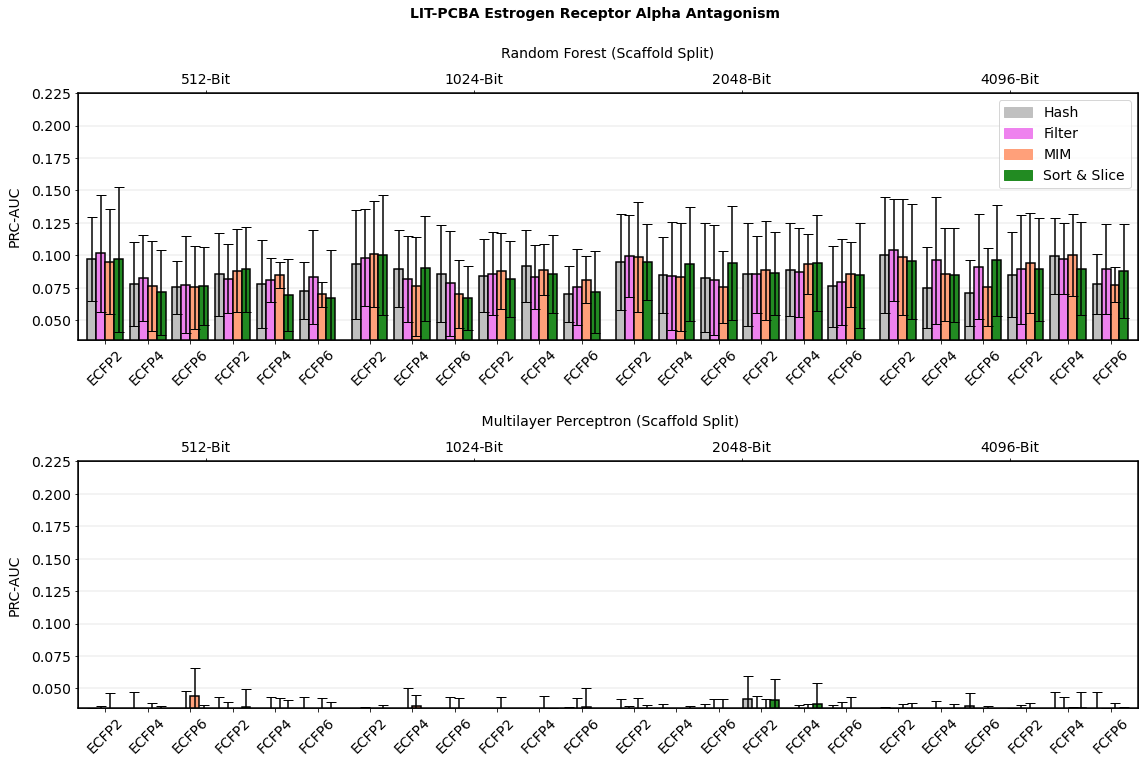

In [17]:
visualise_bar_charts(dataset_name = "lit_pcba_esr_ant", # specify dataset name
                     split_type = "scaff", # specify split type "rand" or "scaff" (for random or scaffold split)
                     metric = "PRC-AUC", # specify performance metric,
                     y_lims = (0.04, 0.22),
                     y_unit = "") # specify unit for y-axis (if applicable)

[0.16213318 0.16901611 0.15891891 0.17237188]
[0.01788898 0.0153089  0.01780919 0.01422271] 

[0.0291579  0.03050296 0.03092159 0.03082153]
[0.00299817 0.00365079 0.00403482 0.0053163 ] 

[0.08423569 0.08697614 0.08317475 0.08674594]
[0.00871132 0.00708155 0.00933342 0.00968227] 

[0.0298373  0.03006176 0.02986487 0.02914234]
[0.00379796 0.00359524 0.00410792 0.00388418] 



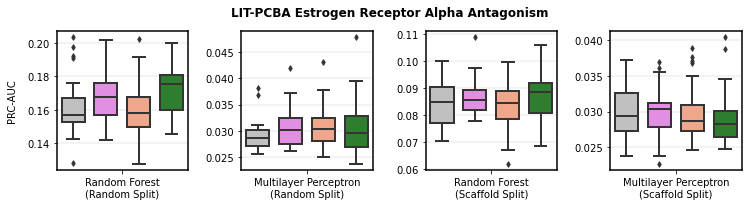

In [4]:
visualise_box_plots(dataset_name = "lit_pcba_esr_ant", # specify dataset name
                    metric = "PRC-AUC", # specify performance metric
                    y_unit = "", # specify unit for y-axis if applicable
                    show_legend = False, # show legend or not
                    show_x_ticks = True) # show text below subplots or not

[0.16213318 0.16901611 0.15891891 0.17237188]
[0.01788898 0.0153089  0.01780919 0.01422271] 

[0.0291579  0.03050296 0.03092159 0.03082153]
[0.00299817 0.00365079 0.00403482 0.0053163 ] 

[0.08423569 0.0858784  0.08317475 0.08674594]
[0.00871132 0.00578098 0.00933342 0.00968227] 

[0.0298373  0.02974784 0.02986487 0.02914234]
[0.00379796 0.00363727 0.00410792 0.00388418] 



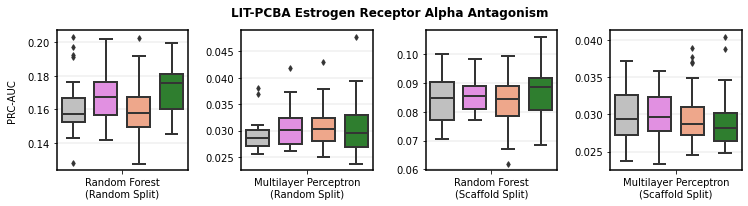

In [18]:
# with old padding with add dim

visualise_box_plots(dataset_name = "lit_pcba_esr_ant", # specify dataset name
                    metric = "PRC-AUC", # specify performance metric
                    y_unit = "", # specify unit for y-axis if applicable
                    show_legend = False, # show legend or not
                    show_x_ticks = True) # show text below subplots or not

[0.16213318 0.16901611 0.15891891 0.17237188]
[0.01788898 0.0153089  0.01780919 0.01422271] 

[0.0291579  0.03050296 0.03092159 0.03082153]
[0.00299817 0.00365079 0.00403482 0.0053163 ] 

[0.08423569 0.0858784  0.08317475 0.08674594]
[0.00871132 0.00578098 0.00933342 0.00968227] 

[0.0298373  0.02955419 0.02986487 0.02914234]
[0.00379796 0.0038788  0.00410792 0.00388418] 



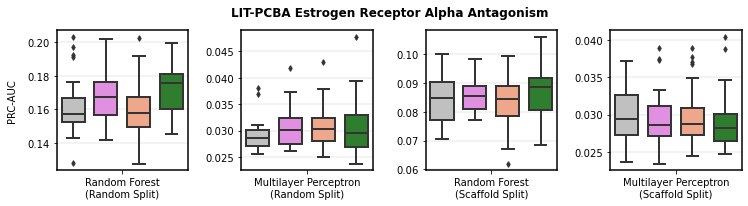

In [21]:
# old function with new padding without add dim

visualise_box_plots(dataset_name = "lit_pcba_esr_ant", # specify dataset name
                    metric = "PRC-AUC", # specify performance metric
                    y_unit = "", # specify unit for y-axis if applicable
                    show_legend = False, # show legend or not
                    show_x_ticks = True) # show text below subplots or not

In [ ]:
# old function with new padding without add dim

visualise_box_plots(dataset_name = "lit_pcba_esr_ant", # specify dataset name
                    metric = "PRC-AUC", # specify performance metric
                    y_unit = "", # specify unit for y-axis if applicable
                    show_legend = False, # show legend or not
                    show_x_ticks = True) # show text below subplots or not

# Lab

In [19]:
def create_ecfp_atom_id_one_hot_encoder_filtered(x_smiles, y, ecfp_settings, discretise_y, random_state = 42):
    
    print("optimised function")
    
    # set random seed
    random.seed(random_state)
    
    # preallocate data structures
    atom_id_set = set()
    atom_id_to_support_list_with_counts = {}
    atom_id_to_info_list = {}
    
    # create set of all occuring atom ids and associated feature matrix with support columns
    for (k, smiles) in enumerate(x_smiles):
        
        (current_atom_id_to_count, current_info) = ecfp_atom_ids_from_smiles(smiles, ecfp_settings)
        atom_id_set = atom_id_set.union(set(current_atom_id_to_count))
        
        for atom_id in set(current_atom_id_to_count):
            atom_id_to_support_list_with_counts[atom_id] = atom_id_to_support_list_with_counts.get(atom_id, [0]*len(x_smiles))
            atom_id_to_support_list_with_counts[atom_id][k] = current_atom_id_to_count[atom_id]
            atom_id_to_info_list[atom_id] = atom_id_to_info_list.get(atom_id, []) + [(smiles, current_info[atom_id])]
    
    # binarise support list so that it only indicates presence/absence of fragments in training compounds
    atom_id_to_support_list = {atom_id: [1 if b > 0 else 0 for b in support_list_with_counts] for (atom_id, support_list_with_counts) in atom_id_to_support_list_with_counts.items()}
    
    print("Number of unique substructures = ", len(atom_id_set))
    
    # step 1: remove fragments with support of cardinality = 1, i.e. fragments which only occur in a single training compound
    atom_ids_single_occ = [atom_id for atom_id in atom_id_set if sum(atom_id_to_support_list[atom_id]) == 1]
    random.shuffle(atom_ids_single_occ)

    while len(atom_ids_single_occ) > 0 and len(atom_id_set) > ecfp_settings["dimension"]:
        
        atom_id_set.remove(atom_ids_single_occ[0])
        atom_id_to_support_list.pop(atom_ids_single_occ[0])
        atom_id_to_support_list_with_counts.pop(atom_ids_single_occ[0])
        atom_ids_single_occ.remove(atom_ids_single_occ[0])
    
    # step 2: remove non-closed fragments, i.e. fragments for which a subfragment (an labelled subgraph) exists which occurs in the exact same set of training compounds (= which has the same support)
    support_tuple_to_atom_id_list = {}
    for (atom_id, support_list) in atom_id_to_support_list.items():
        support_tuple_to_atom_id_list[tuple(support_list)] = support_tuple_to_atom_id_list.get(tuple(support_list), []) + [atom_id]
    
    atom_id_lists_grouped_by_support = [atom_id_list for atom_id_list in support_tuple_to_atom_id_list.values() if len(atom_id_list) >= 2]
    atom_id_to_graph_object = {}
    
    for atom_id_list in atom_id_lists_grouped_by_support:
        for atom_id in atom_id_list:
            
            (smiles, positions) = random.choice(atom_id_to_info_list[atom_id])
            (center_atom_index, radius) = random.choice(positions)
            atom_id_to_graph_object[atom_id] = extract_labelled_circular_subgraph_object(Chem.MolFromSmiles(smiles), center_atom_index, radius, ecfp_settings)
            
    atom_ids_non_closed = []
    
    for atom_id_list in atom_id_lists_grouped_by_support:
        for atom_id in atom_id_list:
            if sum([check_if_strict_labelled_subgraph(atom_id_to_graph_object[other_atom_id], atom_id_to_graph_object[atom_id]) for other_atom_id in atom_id_list]) > 0:
                atom_ids_non_closed.append(atom_id)
            
    random.shuffle(atom_ids_non_closed)

    while len(atom_ids_non_closed) > 0 and len(atom_id_set) > ecfp_settings["dimension"]:
        
        atom_id_set.remove(atom_ids_non_closed[0])
        atom_id_to_support_list.pop(atom_ids_non_closed[0])
        atom_id_to_support_list_with_counts.pop(atom_ids_non_closed[0])
        atom_ids_non_closed.remove(atom_ids_non_closed[0])
    
    # step 3: rank fragments via Chi-square test and make cutoff
    if discretise_y == True:
        y = discretise(y, n_bins = 2, strategy = "quantile")
    
    atom_id_list_chi_squared_sorted = sorted(list(atom_id_set), key = lambda atom_id: chi_squared_p_value(atom_id_to_support_list[atom_id], y)) # replace with atom_id_to_support_list_with_counts to include count-information (if switched on in ecfp_settings) when computing the p-values
    
    while len(atom_id_set) > ecfp_settings["dimension"]:
        
        atom_id_set.remove(atom_id_list_chi_squared_sorted[-1])
        atom_id_to_support_list.pop(atom_id_list_chi_squared_sorted[-1])
        atom_id_to_support_list_with_counts.pop(atom_id_list_chi_squared_sorted[-1])
        atom_id_list_chi_squared_sorted.remove(atom_id_list_chi_squared_sorted[-1])

    final_atom_id_list = list(atom_id_set)
    
    # create integer substructure identifier (= atom id) embedding function
    def atom_id_one_hot_encoder(atom_id):
        
        return one_hot_vec(ecfp_settings["dimension"], final_atom_id_list.index(atom_id)) if atom_id in final_atom_id_list else np.zeros(ecfp_settings["dimension"])
    
    return atom_id_one_hot_encoder


def create_ecfp_vector_multiset(smiles, ecfp_settings, atom_id_one_hot_encoder):
    """
    Transforms an input SMILES string into a (multi)set of one-hot-encoded substructure embeddings (represented as a 2D numpy array) using ecfp_settings to first transform the compound into a set of integer ECFP substructure identifiers (= atom ids), and then using atom_id_one_hot_encoder to vectorise the atom ids. To remain consistent, the embedding function atom_id_one_hot_encoder should be constructued with the same ecfp_settings as is used in this function.
    """
    
    current_atom_id_to_count = ecfp_atom_ids_from_smiles(smiles, ecfp_settings)[0]
    atom_id_list = []
    
    # create list of integer substructure identifiers (= atom ids) in SMILES string (multiplied by their frequencies if ecfp_settings["use_counts"] = True)
    for (atom_id, count) in current_atom_id_to_count.items():
        atom_id_list += [atom_id]*count
    
    # create a representation of the input compound as a (multi)set of substructure emebeddings
    vector_multiset = np.array([atom_id_one_hot_encoder(atom_id) for atom_id in atom_id_list])
    
    return vector_multiset

In [40]:
def create_ecfp_atom_id_one_hot_encoder_filtered(x_smiles, y, ecfp_settings, discretise_y, random_state = 42):

    print("optimised function")


    # set random seed
    random.seed(random_state)
    
    # preallocate data structures
    atom_id_set = set()
    atom_id_to_support_list = defaultdict(lambda: [0]*len(x_smiles)) # the support_list for a given atom_id is a binary list of len(x_smiles) whose i-th entry specifies whether the atom_id is contained in smiles_i
    atom_id_to_info_list = {}
    
    # create set of all occuring atom ids and associated feature matrix with support columns
    for (k, smiles) in enumerate(x_smiles):
        
        (current_atom_id_to_count, current_info) = ecfp_atom_ids_from_smiles(smiles, ecfp_settings)
        atom_id_set = atom_id_set.union(set(current_atom_id_to_count))
        
        for atom_id in current_atom_id_to_count.keys():
            atom_id_to_support_list[atom_id][k] = 1 if current_atom_id_to_count[atom_id] > 0 else 0
            atom_id_to_info_list[atom_id] = atom_id_to_info_list.get(atom_id, []) + [(smiles, current_info[atom_id])]
    
    print("Number of unique circular substructures with specified parameters in molecular training data set = ", len(atom_id_set))
    
    # step 1: remove fragments with support of cardinality = 1, i.e. fragments which only occur in a single training compound
    atom_ids_single_occ = [atom_id for (atom_id, support_list) in atom_id_to_support_list.items() if sum(support_list) == 1]
    random.shuffle(atom_ids_single_occ)

    while len(atom_ids_single_occ) > 0 and len(atom_id_set) > ecfp_settings["dimension"]:
        
        atom_id_set.remove(atom_ids_single_occ[0])
        atom_id_to_support_list.pop(atom_ids_single_occ[0])
        atom_ids_single_occ.remove(atom_ids_single_occ[0])

    # step 2: remove non-closed fragments, i.e. fragments for which a subfragment (an labelled subgraph) exists which occurs in the exact same set of training compounds (= which has the same support)
    support_tuple_to_atom_id_list = defaultdict(lambda: [])
    for (atom_id, support_list) in atom_id_to_support_list.items():
        support_tuple_to_atom_id_list[tuple(support_list)] += [atom_id]
    
    # list of lists of substructure identifiers (= atom ids) that have the same support (and at least length 2)
    atom_id_lists_grouped_by_support = [atom_id_list for atom_id_list in support_tuple_to_atom_id_list.values() if len(atom_id_list) >= 2]
    
    # create a dictionary that maps atom ids to molecular graph objects (assumes a unique mapping from atom ids to graph objects, which is true up to rare hash collisions intrinsic to the ECFP algorithm during the generation of the atom ids)
    atom_id_to_graph_object = {}
    
    for atom_id_list in atom_id_lists_grouped_by_support:
        for atom_id in atom_id_list:
            
            (smiles, positions) = random.choice(atom_id_to_info_list[atom_id])
            (center_atom_index, radius) = random.choice(positions)
            atom_id_to_graph_object[atom_id] = extract_labelled_circular_subgraph_object(Chem.MolFromSmiles(smiles), center_atom_index, radius, ecfp_settings)
    
    # create list of non-closed fragments
    atom_ids_non_closed = [atom_id for atom_id_list in atom_id_lists_grouped_by_support for atom_id in atom_id_list if sum([check_if_strict_labelled_subgraph(atom_id_to_graph_object[other_atom_id], atom_id_to_graph_object[atom_id]) for other_atom_id in atom_id_list]) > 0]
    random.shuffle(atom_ids_non_closed)

    while len(atom_ids_non_closed) > 0 and len(atom_id_set) > ecfp_settings["dimension"]:
        
        atom_id_set.remove(atom_ids_non_closed[0])
        atom_id_to_support_list.pop(atom_ids_non_closed[0])
        atom_ids_non_closed.remove(atom_ids_non_closed[0])
 
    # step 3: rank fragments via Chi-square test and remove fragments whose p-value is too high
    if discretise_y == True:
        y = discretise(y, n_bins = 2, strategy = "quantile")
    
    atom_id_list_sorted = sorted(list(atom_id_set), key = lambda atom_id: chi_squared_p_value(atom_id_to_support_list[atom_id], y))
    
    while len(atom_id_set) > ecfp_settings["dimension"]:
        
        atom_id_set.remove(atom_id_list_sorted[-1])
        atom_id_list_sorted.remove(atom_id_list_sorted[-1])

    final_atom_id_list = list(atom_id_set)
    
    # create integer substructure identifier (= atom id) embedding function
    def atom_id_one_hot_encoder(atom_id):
        
        return one_hot_vec(ecfp_settings["dimension"], final_atom_id_list.index(atom_id)) if atom_id in final_atom_id_list else np.zeros(ecfp_settings["dimension"])
    
    return atom_id_one_hot_encoder


def create_ecfp_vector_multiset(smiles, ecfp_settings, atom_id_one_hot_encoder):
    """
    Transforms an input SMILES string into a (multi)set of one-hot-encoded substructure embeddings (represented as a 2D numpy array) using ecfp_settings to first transform the compound into a set of integer ECFP substructure identifiers (= atom ids), and then using atom_id_one_hot_encoder to vectorise the atom ids. To remain consistent, the embedding function atom_id_one_hot_encoder should be constructued with the same ecfp_settings as is used in this function.
    """
    
    current_atom_id_to_count = ecfp_atom_ids_from_smiles(smiles, ecfp_settings)[0]
    atom_id_list = []
    
    # create list of integer substructure identifiers (= atom ids) in SMILES string (multiplied by their frequencies if ecfp_settings["use_counts"] = True)
    for (atom_id, count) in current_atom_id_to_count.items():
        atom_id_list += [atom_id]*count
    
    # create a representation of the input compound as a (multi)set of substructure emebeddings
    vector_multiset = np.array([atom_id_one_hot_encoder(atom_id) for atom_id in atom_id_list])
    
    return vector_multiset

In [16]:
def create_ecfp_atom_id_one_hot_encoder_filtered(x_smiles, y, ecfp_settings, discretise_y, random_state = 42):
    
    print("with old padding with add dim")
    
    # set random seed
    random.seed(random_state)
    
    # preallocate data structures
    atom_id_set = set()
    atom_id_to_support_list_with_counts = {}
    atom_id_to_info_list = {}
    
    # create set of all occuring atom ids and associated feature matrix with support columns
    for (k, smiles) in enumerate(x_smiles):
        
        (current_atom_id_to_count, current_info) = ecfp_atom_ids_from_smiles(smiles, ecfp_settings)
        atom_id_set = atom_id_set.union(set(current_atom_id_to_count))
        
        for atom_id in set(current_atom_id_to_count):
            atom_id_to_support_list_with_counts[atom_id] = atom_id_to_support_list_with_counts.get(atom_id, [0]*len(x_smiles))
            atom_id_to_support_list_with_counts[atom_id][k] = current_atom_id_to_count[atom_id]
            atom_id_to_info_list[atom_id] = atom_id_to_info_list.get(atom_id, []) + [(smiles, current_info[atom_id])]
    
    # binarise support list so that it only indicates presence/absence of fragments in training compounds
    atom_id_to_support_list = {atom_id: [1 if b > 0 else 0 for b in support_list_with_counts] for (atom_id, support_list_with_counts) in atom_id_to_support_list_with_counts.items()}
    
    print("Number of unique substructures = ", len(atom_id_set))
    
    # step 1: remove fragments with support of cardinality = 1, i.e. fragments which only occur in a single training compound
    atom_ids_single_occ = [atom_id for atom_id in atom_id_set if sum(atom_id_to_support_list[atom_id]) == 1]
    random.shuffle(atom_ids_single_occ)

    while len(atom_ids_single_occ) > 0 and len(atom_id_set) > ecfp_settings["dimension"]:
        
        atom_id_set.remove(atom_ids_single_occ[0])
        atom_id_to_support_list.pop(atom_ids_single_occ[0])
        atom_id_to_support_list_with_counts.pop(atom_ids_single_occ[0])
        atom_ids_single_occ.remove(atom_ids_single_occ[0])
    
    # step 2: remove non-closed fragments, i.e. fragments for which a subfragment (an labelled subgraph) exists which occurs in the exact same set of training compounds (= which has the same support)
    support_tuple_to_atom_id_list = {}
    for (atom_id, support_list) in atom_id_to_support_list.items():
        support_tuple_to_atom_id_list[tuple(support_list)] = support_tuple_to_atom_id_list.get(tuple(support_list), []) + [atom_id]
    
    atom_id_lists_grouped_by_support = [atom_id_list for atom_id_list in support_tuple_to_atom_id_list.values() if len(atom_id_list) >= 2]
    atom_id_to_graph_object = {}
    
    for atom_id_list in atom_id_lists_grouped_by_support:
        for atom_id in atom_id_list:
            
            (smiles, positions) = random.choice(atom_id_to_info_list[atom_id])
            (center_atom_index, radius) = random.choice(positions)
            atom_id_to_graph_object[atom_id] = extract_labelled_circular_subgraph_object(Chem.MolFromSmiles(smiles), center_atom_index, radius, ecfp_settings)
            
    atom_ids_non_closed = []
    
    for atom_id_list in atom_id_lists_grouped_by_support:
        for atom_id in atom_id_list:
            if sum([check_if_strict_labelled_subgraph(atom_id_to_graph_object[other_atom_id], atom_id_to_graph_object[atom_id]) for other_atom_id in atom_id_list]) > 0:
                atom_ids_non_closed.append(atom_id)
            
    random.shuffle(atom_ids_non_closed)

    while len(atom_ids_non_closed) > 0 and len(atom_id_set) > ecfp_settings["dimension"]:
        
        atom_id_set.remove(atom_ids_non_closed[0])
        atom_id_to_support_list.pop(atom_ids_non_closed[0])
        atom_id_to_support_list_with_counts.pop(atom_ids_non_closed[0])
        atom_ids_non_closed.remove(atom_ids_non_closed[0])
    
    # step 3: rank fragments via Chi-square test and make cutoff
    if discretise_y == True:
        y = discretise(y, n_bins = 2, strategy = "quantile")
    
    atom_id_list_chi_squared_sorted = sorted(list(atom_id_set), key = lambda atom_id: chi_squared_p_value(atom_id_to_support_list[atom_id], y)) # replace with atom_id_to_support_list_with_counts to include count-information (if switched on in ecfp_settings) when computing the p-values
    
    while len(atom_id_set) > ecfp_settings["dimension"]:
        
        atom_id_set.remove(atom_id_list_chi_squared_sorted[-1])
        atom_id_to_support_list.pop(atom_id_list_chi_squared_sorted[-1])
        atom_id_to_support_list_with_counts.pop(atom_id_list_chi_squared_sorted[-1])
        atom_id_list_chi_squared_sorted.remove(atom_id_list_chi_squared_sorted[-1])

    final_atom_id_list = list(atom_id_set)
    
    zero_padding_dim = int(-min(len(final_atom_id_list) - ecfp_settings["dimension"], 0)) + 1
    final_atom_id_list_to_one_hot_vecs = dict([(atom_id, one_hot_vec(len(final_atom_id_list) + zero_padding_dim, k)) for (k, atom_id) in enumerate(final_atom_id_list)])
    
    def atom_id_one_hot_encoder(atom_id):
        
        other_vec = one_hot_vec(len(final_atom_id_list) + zero_padding_dim, len(final_atom_id_list) + zero_padding_dim - 1)
        
        return final_atom_id_list_to_one_hot_vecs.get(atom_id, other_vec)
    
    return atom_id_one_hot_encoder




def create_ecfp_vector_multiset(smiles, ecfp_settings, atom_id_one_hot_encoder):
    
    atom_id_dict = ecfp_atom_ids_from_smiles(smiles, ecfp_settings)[0]
    atom_id_list = []
    
    for key in atom_id_dict:
        atom_id_list += [key]*atom_id_dict[key]
    
    vector_multiset = np.array([atom_id_one_hot_encoder(atom_id) for atom_id in atom_id_list])
    vector_multiset = np.delete(vector_multiset, np.where(vector_multiset[:,-1] == 1)[0], axis = 0)[:,0:-1]
    
    return vector_multiset

In [15]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit.DataStructs.cDataStructs import UIntSparseIntVect
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import chi2_contingency



def ecfp_invariants(mol):
    """
    A function that maps an RDKit mol object to a list of hashed integer identifiers (= initial atom ids) describing the initial standard ECFP atomic invariants.
    """
    
    invs = []
    
    for k in range(mol.GetNumAtoms()):
    
        fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius = 0, atomInvariantsGenerator = rdFingerprintGenerator.GetMorganAtomInvGen(includeRingMembership = True))
        fingerprint = fp_gen.GetSparseCountFingerprint(mol, fromAtoms = [k])        
        invs.append(list(fingerprint.GetNonzeroElements().keys())[0])

    return invs



def fcfp_invariants(mol):
    """
     A function that maps an RDKit mol object to a list of hashed integer identifiers (= initial atom ids) describing the initial pharmacophoric FCFP atomic invariants.
    """
    
    invs = []
    
    for k in range(mol.GetNumAtoms()):
    
        fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius = 0, atomInvariantsGenerator = rdFingerprintGenerator.GetMorganFeatureAtomInvGen())
        fingerprint = fp_gen.GetSparseCountFingerprint(mol, fromAtoms = [k])        
        invs.append(list(fingerprint.GetNonzeroElements().keys())[0])

    return invs



def one_hot_vec(dim, k):
    """
    Creates a one-hot vector that has 0s everywhere except in its k-th component.
    """
    
    vec = np.zeros(dim)
    vec[k] = 1
    
    return vec.astype(int)



def ecfp_atom_ids_from_smiles(smiles, ecfp_settings):
    """
    A function that takes as input a SMILES string and a dictionary of ECFP settings and outputs a pair of dictionaries. The keys of each dictionary are given by the hashed integer ECFP substructure identifiers ( = the set of generated atom ids) in the input molecule. The first dictionary maps each atom id to its count (i.e. how often it appears in the input compound). If ecfp_settings["use_counts"] = False, then all atom ids are mapped to 1. The second dictionary named info_dict maps each atom id to a tuple containing the location(s) of the associated circular substructure in the input compound (specified via the center atom and the radius).
    
    """
    
    mol = Chem.MolFromSmiles(smiles)
    
    info_dict = {}
    
    fp = GetMorganFingerprint(mol,
                              radius = ecfp_settings["radius"], # 0 or 1 or 2 or ...
                              useCounts = ecfp_settings["use_counts"], # True or False
                              invariants = ecfp_settings["mol_to_invs_function"](mol), # ecfp_invariants(mol) or fcfp_invariants(mol) 
                              useChirality = ecfp_settings["use_chirality"], # True or False
                              useBondTypes = ecfp_settings["use_bond_invs"], # True or False
                              bitInfo = info_dict)

    return (UIntSparseIntVect.GetNonzeroElements(fp), info_dict)



def create_ecfp_atom_id_one_hot_encoder_sort_and_slice(x_smiles, ecfp_settings, break_ties_with = "sorted_list_command"):
    """
    Takes as input a list of SMILES strings x_smiles = [smiles_1, smiles_2, ...] and a dictionary of ECFP settings and gives as output a function atom_id_one_hot_encoder that maps 
    integer substructure identifiers (= atom ids) to one-hot encoded vector representations of dimension ecfp_settings["dimension"]. 
    The components of the vector representation are sorted by prevalence, whereby the substructure identifiers that appear in the most compounds in x_smiles appear first.
    Ties are either broken using the arbitrary ordering induced via the command sorted(list(...), ...) or via the abritrary ordering induced by the integer atom ids themselves.
    Substructure identifiers that are not part of the most frequent ecfp_settings["dimension"] substructures (or not in x_smiles at all) are all mapped to a vector of 0s. 
    If ecfp_settings["dimension"] is larger than the number of unique substructure identifiers in all compounds in x_smiles, then the vector representation is padded with 0s 
    to reach the desired length. 
    """
    
    # preallocate data structures
    atom_id_set = set()
    atom_id_to_support_list = defaultdict(lambda: [0]*len(x_smiles)) # the support_list for a given atom_id is a binary list of len(x_smiles) whose i-th entry specifies whether the atom_id is contained in smiles_i
    
    # create set of all atom id in x_smiles and binary substructural training feature vector for each atom_id in the form of a dictionary atom_id_to_support_list
    for (k, smiles) in enumerate(x_smiles):
        
        current_atom_id_to_count = ecfp_atom_ids_from_smiles(smiles, ecfp_settings)[0]
        atom_id_set = atom_id_set.union(set(current_atom_id_to_count))
        
        for atom_id in current_atom_id_to_count.keys():
            atom_id_to_support_list[atom_id][k] = 1 if current_atom_id_to_count[atom_id] > 0 else 0
            
    print("Number of unique circular substructures with specified parameters in molecular training data set = ", len(atom_id_to_support_list.keys()))
    
    # create list of atom ids sorted by prevalence in x_smiles (ties are either broken using the arbitrary ordering induced via sorted(list(...), ...) or the arbitrary ordering induced by the integer atom ids themselves)
    if break_ties_with == "sorted_list_command":
        atom_id_list_sorted = sorted(list(atom_id_set), key = lambda atom_id: sum(atom_id_to_support_list[atom_id]), reverse = True)
    elif break_ties_with == "atom_ids":
        atom_id_list_sorted = sorted(list(atom_id_set), key = lambda atom_id: (sum(atom_id_to_support_list[atom_id]), -atom_id), reverse = True)
    
    # create integer substructure identifier (= atom id) embedding function
    def atom_id_one_hot_encoder(atom_id):
        
        return one_hot_vec(ecfp_settings["dimension"], atom_id_list_sorted.index(atom_id)) if atom_id in atom_id_list_sorted[0: ecfp_settings["dimension"]] else np.zeros(ecfp_settings["dimension"])
    
    return atom_id_one_hot_encoder



def discretise(y_cont, n_bins = 2, strategy = "uniform"):
    """
    Discretise continuous array.
    """
    
    discretiser = KBinsDiscretizer(n_bins = n_bins, encode = "ordinal", strategy = strategy)
    y_disc = list(discretiser.fit_transform(np.array(y_cont).reshape(-1,1)).reshape(-1).astype(int))
    
    return y_disc



def chi_squared_p_value(x_discrete, y_discrete):
    """
    Return p-value of a Chi-squared significance test between two samples x_discrete and y_discrete.
    """
    
    df = pd.DataFrame(data = {"x_discrete": x_discrete, "y_discrete": y_discrete})
    contingency_table = pd.crosstab(index = df["x_discrete"], columns = df["y_discrete"]).values
    (chi_squared, p_value, degrees_of_freedom, expected_frequencies) = chi2_contingency(contingency_table)

    return p_value






def remove_random_element(my_list, random_state = 42):
    """
    Remove random element from a list and return the new list.
    """
    
    random.seed(random_state)
    my_list.pop(random.randrange(len(my_list)))
    
    return my_list



def create_ecfp_atom_id_one_hot_encoder_mim(x_smiles, y, ecfp_settings, discretise_y, base = 2, random_state = 42):
    """
    Takes as input a list of SMILES strings x_smiles = [smiles_1, smiles_2, ...], a list of target values y, and a dictionary of ECFP settings and gives as output a function atom_id_one_hot_encoder that maps integer substructure identifiers (= atom ids) to 
    one-hot encoded vector representations of dimension ecfp_settings["dimension"] based on a substructure selection according to mutual information maximisation between substructural features and the target y. 
    If y is continuous, it is discretised before the mutual-information computation. Substructure identifiers that do not occur in the selection are all mapped to a vector of 0s. 
    If ecfp_settings["dimension"] is larger than the number of unique substructure identifiers in all compounds in x_smiles, then the vector representation is padded with 0s to reach the desired length.
    """
    
    # set random seed
    random.seed(random_state)
    
    # preallocate data structures
    atom_id_set = set()
    atom_id_to_support_list = defaultdict(lambda: [0]*len(x_smiles)) # the support_list for a given atom_id is a binary list of len(x_smiles) whose i-th entry specifies whether the atom_id is contained in smiles_i
    
    # create set of all occuring atom ids and associated feature matrix with support columns
    for (k, smiles) in enumerate(x_smiles):
        
        current_atom_id_to_count = ecfp_atom_ids_from_smiles(smiles, ecfp_settings)[0]
        atom_id_set = atom_id_set.union(set(current_atom_id_to_count))
        
        for atom_id in set(current_atom_id_to_count):
            atom_id_to_support_list[atom_id][k] = 1 if current_atom_id_to_count[atom_id] > 0 else 0
            
    print("Number of unique circular substructures with specified parameters in molecular training data set = ", len(atom_id_set))
    
    # step 1: randomly drop fragments for which a fragment with same support exists
    support_tuple_to_atom_id_list = defaultdict(lambda: [])
    for (atom_id, support_list) in atom_id_to_support_list.items():
        support_tuple_to_atom_id_list[tuple(support_list)] += [atom_id]
    
    # list of lists of substructure identifiers (= atom ids) that have the same support (and at least length 2)
    atom_id_lists_grouped_by_support = [atom_id_list for atom_id_list in support_tuple_to_atom_id_list.values() if len(atom_id_list) >= 2]
    
    # atom ids for which there exists another atom id with the same support
    atom_ids_redundant = [atom_id for atom_id_list in atom_id_lists_grouped_by_support for atom_id in remove_random_element(atom_id_list, random_state = random_state)]
    random.shuffle(atom_ids_redundant)

    while len(atom_ids_redundant) > 0 and len(atom_id_set) > ecfp_settings["dimension"]:
        
        atom_id_set.remove(atom_ids_redundant[0])
        atom_id_to_support_list.pop(atom_ids_redundant[0])
        atom_ids_redundant.remove(atom_ids_redundant[0])
    
    # step 2: sort fragments by mutual information with (discretised) target y and choose the most informative substructures only
    if discretise_y == True:
        y = discretise(y, n_bins = 2, strategy = "quantile")

    atom_id_list_sorted = sorted(list(atom_id_set), key = lambda atom_id: mi(atom_id_to_support_list[atom_id], y, base = base), reverse = True)
    
    # create integer substructure identifier (= atom id) embedding function
    def atom_id_one_hot_encoder(atom_id):
        
        return one_hot_vec(ecfp_settings["dimension"], atom_id_list_sorted.index(atom_id)) if atom_id in atom_id_list_sorted[0: ecfp_settings["dimension"]] else np.zeros(ecfp_settings["dimension"])
    
    return atom_id_one_hot_encoder



def create_ecfp_vector_multiset(smiles, ecfp_settings, atom_id_one_hot_encoder):
    """
    Transforms an input SMILES string into a (multi)set of one-hot-encoded substructure embeddings (represented as a 2D numpy array) using ecfp_settings to first transform the compound into a set of integer ECFP substructure identifiers (= atom ids), and then using atom_id_one_hot_encoder to vectorise the atom ids. To remain consistent, the embedding function atom_id_one_hot_encoder should be constructued with the same ecfp_settings as is used in this function.
    """
    
    current_atom_id_to_count = ecfp_atom_ids_from_smiles(smiles, ecfp_settings)[0]
    atom_id_list = []
    
    # create list of integer substructure identifiers (= atom ids) in SMILES string (multiplied by their frequencies if ecfp_settings["use_counts"] = True)
    for (atom_id, count) in current_atom_id_to_count.items():
        atom_id_list += [atom_id]*count
    
    # create a representation of the input compound as a (multi)set of substructure emebeddings
    vector_multiset = np.array([atom_id_one_hot_encoder(atom_id) for atom_id in atom_id_list])
    
    return vector_multiset



def create_ecfp_featuriser(ecfp_settings,
                           x_smiles_train = None,
                           y_train = None,
                           discretise_y = None,
                           base = 2,
                           random_state = 42):
    
    """
    Create a featurisation function "featuriser" that takes as input a list of SMILES strings x_smiles and gives as output a numpy array whose rows are vectorial ECFP representations for the input compounds. The option ecfp_settings["pool_method"] determines which substructure pooling method the output featuriser is equipped with.
    """
    
    if ecfp_settings["pool_method"] == "hashed":
        
        def featuriser(x_smiles):
            
            x_mol = [Chem.MolFromSmiles(smiles) for smiles in x_smiles]
            
            X_fp = np.array([Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol,
                                                                                 radius = ecfp_settings["radius"],
                                                                                 nBits = ecfp_settings["dimension"],
                                                                                 invariants = ecfp_settings["mol_to_invs_function"](mol),
                                                                                 useBondTypes = ecfp_settings["use_bond_invs"],
                                                                                 useChirality = ecfp_settings["use_chirality"]) for mol in x_mol])
            return X_fp
        
        return featuriser
    
    elif ecfp_settings["pool_method"] != "hashed":
        
        if ecfp_settings["pool_method"] == "sort_and_slice":
            atom_id_one_hot_encoder = create_ecfp_atom_id_one_hot_encoder_sort_and_slice(x_smiles_train, ecfp_settings)
        elif ecfp_settings["pool_method"] == "filtered":
            atom_id_one_hot_encoder = create_ecfp_atom_id_one_hot_encoder_filtered(x_smiles_train, y_train, ecfp_settings, discretise_y, random_state)
        elif ecfp_settings["pool_method"] == "mim":
            atom_id_one_hot_encoder = create_ecfp_atom_id_one_hot_encoder_mim(x_smiles_train, y_train, ecfp_settings, discretise_y, base, random_state)
        
        def featuriser(x_smiles):
            
            X_fp = np.zeros((len(x_smiles), ecfp_settings["dimension"]))

            for (k, smiles) in enumerate(x_smiles):
                
                X_fp[k,:] = np.sum(create_ecfp_vector_multiset(smiles, ecfp_settings, atom_id_one_hot_encoder), axis = 0)
                
            return X_fp
        
        return featuriser

In [14]:
import graph_tool as gt
from graph_tool.topology import subgraph_isomorphism



def extract_circular_subgraph_vertices_and_edges(mol, center_atom_index, radius):
    
    V = {center_atom_index}
    E = set({})
    
    for r in range(radius):
        for current_atom_index in V:
            
            current_neighbours = {atom.GetIdx() for atom in mol.GetAtomWithIdx(current_atom_index).GetNeighbors()}
            V = V.union(current_neighbours)
            E = E.union({tuple(sorted([current_atom_index, neighbour_index])) for neighbour_index in current_neighbours})

    return V, E



def get_bond_invs(mol, bond_atom_ids, use_bond_invs, use_chirality):
    
    bond = mol.GetBondBetweenAtoms(bond_atom_ids[0], bond_atom_ids[1])
    
    if use_bond_invs == False:
        
        return 1
    
    else:
        
        if use_chirality == False:
            
            return abs(hash((str(bond.GetBondType()),)) % 10000000)
        
        else:
            
            if str(bond.GetBondType()) == "DOUBLE":
            
                return abs(hash((str(bond.GetBondType()), str(bond.GetStereo()))) % 10000000)
            
            else:
                
                return abs(hash((str(bond.GetBondType()),)) % 10000000)



def extract_labelled_circular_subgraph_object(mol, center_atom_index, radius, ecfp_settings):
    
    # create vertices and edges
    (V, E) = extract_circular_subgraph_vertices_and_edges(mol, center_atom_index, radius)

    # create vertex label dict
    vertices_to_labels = {}
    invs = ecfp_settings["mol_to_invs_function"](mol)
    
    for v in V:
        vertices_to_labels[v] = invs[v]

    # create edge label dict
    edges_to_labels = {}
    
    for (v, w) in E:
        edges_to_labels[(v, w)] = get_bond_invs(mol = mol, bond_atom_ids = (v, w), use_bond_invs = ecfp_settings["use_bond_invs"], use_chirality = ecfp_settings["use_chirality"])
    
    # standardise graph data via isomorphism so that the n vertices are mapped to {0,...,n-1}
    isom = dict(list(zip(list(V), list(range(len(V))))))
    V = set({isom[v] for v in V})
    E = set({(isom[v], isom[w]) for (v, w) in E})
    vertices_to_labels = {isom[v]: vertices_to_labels[v] for v in vertices_to_labels.keys()}
    edges_to_labels = {(isom[v], isom[w]) : edges_to_labels[(v, w)] for (v, w) in edges_to_labels.keys()}
    
    # create topological graph object
    G = gt.Graph(directed = False)
    
    G.add_vertex(n = len(V))
    
    for (v,w) in E:
        G.add_edge(v, w)

    # create vertex property map
    vertex_labels = G.new_vertex_property("long")
    
    for vertex in G.vertices():
        vertex_labels[vertex] = vertices_to_labels[int(vertex)]
    
    # create edge property map
    edge_labels = G.new_edge_property("long")
    
    for edge in G.edges():
        edge_labels[edge] = edges_to_labels[tuple(edge)]
    
    return (G, vertex_labels, edge_labels)



def check_if_strict_labelled_subgraph(G_sub_with_labels, G_with_labels):
    
    (G_sub, G_sub_vertex_labels, G_sub_edge_labels) = G_sub_with_labels
    (G, G_vertex_labels, G_edge_labels) = G_with_labels
    
    # if potential subgraph has more or equal amount of nodes than graph, then it cannot be a strict subgraph
    if G_sub.num_vertices() >= G.num_vertices():
        
        return False
    
    # check if strict subgraph (also considering labels)
    else:
    
        list_of_vertex_maps = subgraph_isomorphism(G_sub, 
                                                   G, 
                                                   max_n = 1, 
                                                   vertex_label = (G_sub_vertex_labels, G_vertex_labels), 
                                                   edge_label = (G_sub_edge_labels, G_edge_labels), 
                                                   induced = False)

        return True if len(list_of_vertex_maps) > 0 else False